In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
from skimage import io, transform
import matplotlib.image as mpimg
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import scipy
import random
import pickle
import scipy.io as sio
from PIL import ImageEnhance
from skimage.util import random_noise
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.ion()

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from skimage import io
import torch
from torchvision import transforms
import torchvision
from skimage import color
from torch.optim import lr_scheduler
from torchvision.utils import make_grid

import nibabel

In [2]:
%matplotlib inline
def show(img):
    
    npimg = img.numpy()
    #print(npimg.shape)
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

In [3]:
import pickle
def pickling(file,path):
    pickle.dump(file,open(path,'wb'))
def unpickling(path):
    file_return=pickle.load(open(path,'rb'))
    return file_return

In [4]:
available_segments = [  0,   2,   3,   4,   5,   7,   8,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  24,  26,  28,  30,  31,  41,  42,  43,  44,  46,
        47,  49,  50,  51,  52,  53,  54,  58,  60,  62,  63,  72, 
        85, 251, 252, 253, 254, 255]

In [5]:
class BrainImages(Dataset):
    def __init__(self, image_dir, label_dir, train_data = False, flipping = False, rotation = True, translation = True, contrast = True, noise = True):
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.flipping = flipping
        self.rotation = rotation
        self.translation = translation
        self.train_data = train_data
        self.contrast = contrast
        self.noise = noise

    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self,idx):
        image_path = self.image_dir[idx]
        aseg_path = self.label_dir[idx]
        
        img_orig = nibabel.freesurfer.mghformat.MGHImage.from_filename(image_path)
        image = img_orig.get_data().astype(np.float64)
        aseg_img = nibabel.freesurfer.mghformat.MGHImage.from_filename(aseg_path)
        aseg_img = aseg_img.get_data().astype(np.float64)
                
        flip = random.random() > 0.5
        angle = random.uniform(-5,5)
        dx = np.round(random.uniform(-10,10))
        dy = np.round(random.uniform(-10,10))
        factor = random.uniform(0.6,0.1)
        im = image[0]
        if self.train_data:
            if self.noise:
                noise = np.random.randn(256,256)*2
                im = im + noise
        im = Image.fromarray(im)
        target = Image.fromarray(aseg_img[0])
        if self.train_data:
            if self.flipping and flip:
                im = im.transpose(0)
                target = target.transpose(0)
            if self.rotation:
                im = im.rotate(angle)
                target = target.rotate(angle)
            if self.translation:
                im = im.transform((256,256),0, (1,0,dx,0,1,dy))
                target = target.transform((256,256),0,(1,0,dx,0,1,dy))
                
            if self.contrast:
                if im.mode != 'L':
                    im = im.convert('L')
                    enhancer = ImageEnhance.Color(im)
                    im = enhancer.enhance(factor)

                
        im = torch.from_numpy(np.array(im, np.float64, copy=False).reshape((1,256,256)))
        target = np.array(target, np.float64, copy=False)
        target_label = np.zeros((44,256,256))
        for i,a in enumerate(available_segments):
            target_label[i,:,:] = (target==a).astype(int)
        target_label = torch.from_numpy(target_label)
        im = (im - torch.min(im))/(torch.max(im) - torch.min(im)+1e-7)
        sample = {'x':im,'y':target_label} 
        return sample

In [6]:
# # torch.from_numpy()
# train_file_names = unpickling("/scratch/ark576/train_file_names")
# train_label_names = unpickling("/scratch/ark576/train_label_names")
# rand1 = np.arange(len(train_file_names))
# np.random.shuffle(rand1)
# rand1 = rand1[:1000]

# val_file_names = unpickling("/scratch/ark576/val_file_names")
# val_label_names = unpickling("/scratch/ark576/val_label_names")
# rand2 = np.arange(len(val_file_names))
# np.random.shuffle(rand2)
# rand2 = rand2[:250]

# test_file_names = unpickling("/scratch/ark576/test_file_names")
# test_label_names = unpickling("/scratch/ark576/test_label_names")
# rand3 = np.arange(len(test_file_names))
# np.random.shuffle(rand3)
# rand3 = rand3[:3]




In [6]:
file_names = pd.read_csv("all_complete_path.csv")

In [7]:
file_names.head()

,left_to_right_raw,left_to_right_segmented,top_to_bottom_raw,top_to_bottom_segmented,back_to_front_raw,back_to_front_segmented
0,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
1,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
2,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
3,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...
4,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/left_to_right...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/top_to_bottom...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...,/cbi/hcp/hcp_seg/aseg_all_slices/back_to_front...


In [8]:
train_subjects = unpickling("train_subject_index")
val_subjects = unpickling("val_subject_index")
test_subjects = unpickling("test_subject_index")

In [9]:
full_train_raw = list(file_names.iloc[train_subjects,2])
full_train_seg = list(file_names.iloc[train_subjects,3])

full_val_raw = list(file_names.iloc[val_subjects,2])
full_val_seg = list(file_names.iloc[val_subjects,3])

full_test_raw = list(file_names.iloc[test_subjects,2])
full_test_seg = list(file_names.iloc[test_subjects,3])

In [10]:
rand1 = np.arange(len(full_train_raw))
np.random.shuffle(rand1)
rand1 = rand1[:2000]

rand2 = np.arange(len(val_subjects))
np.random.shuffle(rand2)
rand2 = rand2[:500]

rand3 = np.arange(len(test_subjects))
np.random.shuffle(rand3)
rand3 = rand3[:3]

In [11]:
transformed_dataset = {'train': BrainImages(np.array(full_train_raw)[rand1],np.array(full_train_seg)[rand1], train_data= True, flipping=False),
                       'validate': BrainImages(np.array(full_val_raw)[rand2],np.array(full_val_seg)[rand2]),
                       'test': BrainImages(np.array(full_test_raw)[rand3],np.array(full_test_seg)[rand3])
                                               }

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=28,
                        shuffle=True, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}

In [12]:
inputs = next(iter(dataloader['train']))

In [46]:
# x = inputs['x'][6,0,:,:].numpy()

In [88]:
# y = inputs['x'][6,0,:,:].numpy()

In [13]:
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(x,y)
# mse

In [13]:
# 10*np.log10(1/mse)

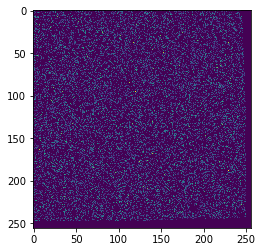

In [14]:
plt.imshow(inputs['x'][6,0,:,:].numpy())



In [15]:
# plt.figure(figsize=(25,25))
# plt.imshow(x)



In [16]:
# plt.figure(figsize=(25,25))
# plt.imshow(y)

# # noise



In [32]:
# import scipy
# from numpy import nanmean
# snr = scipy.stats.signaltonoise(inputs['x'][3,0,:,:].numpy(), axis=None)

In [17]:
# from scipy.ndimage.measurements import variance
# variance(inputs['x'][7,0,:,:].numpy())

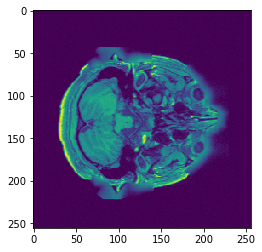

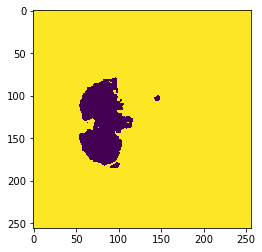

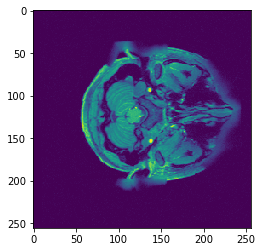

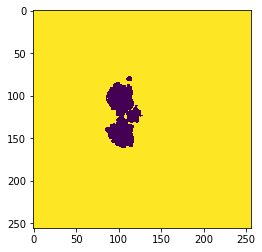

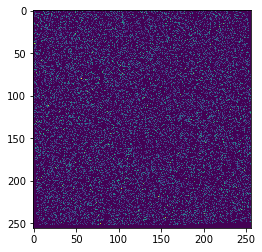

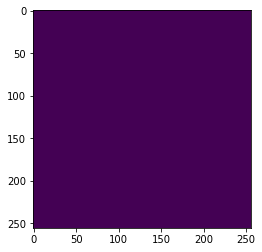

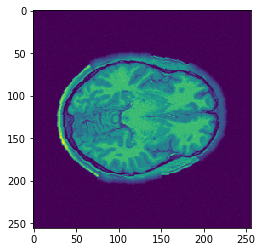

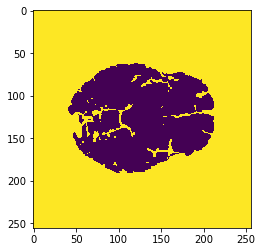

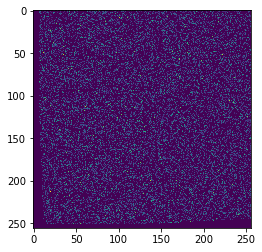

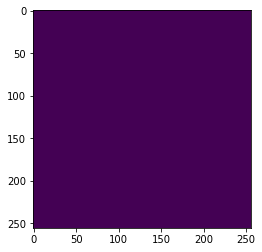

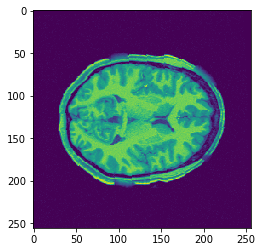

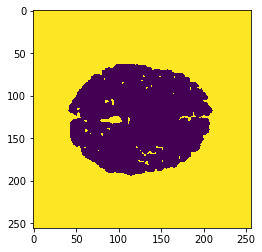

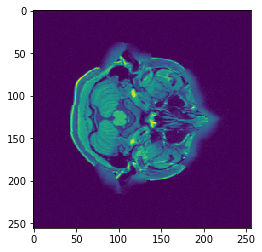

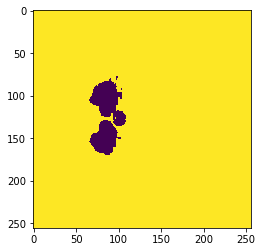

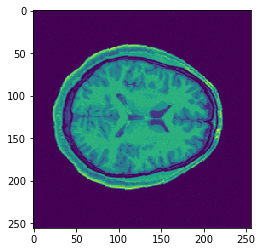

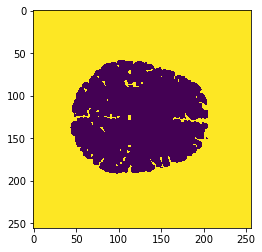

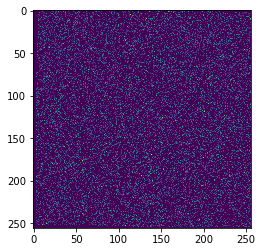

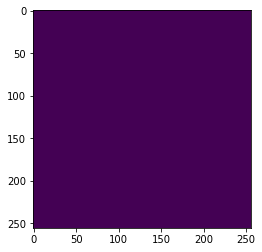

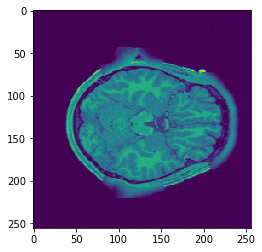

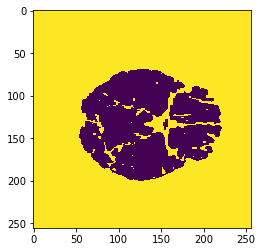

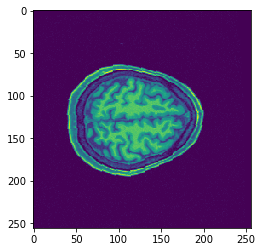

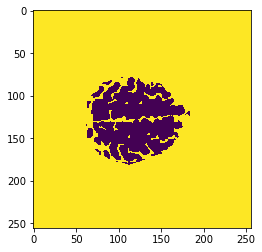

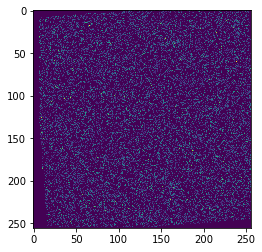

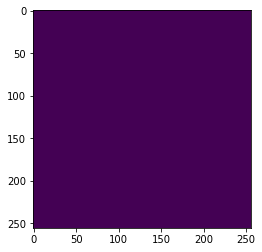

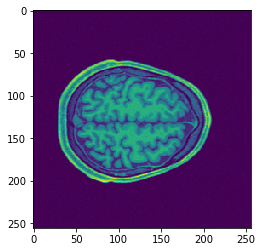

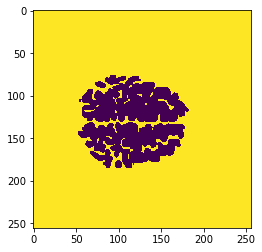

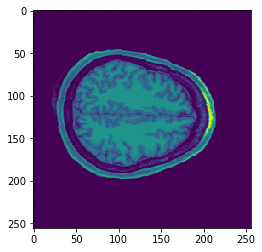

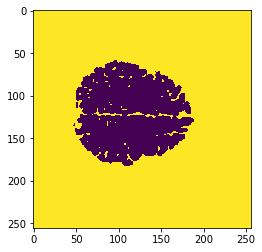

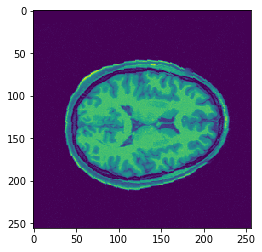

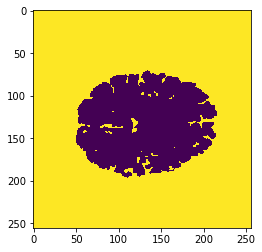

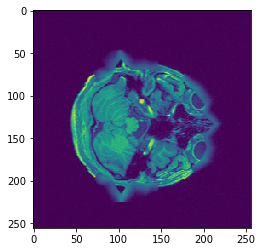

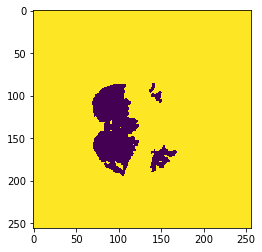

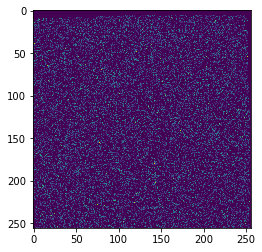

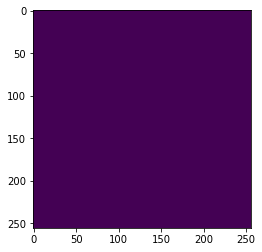

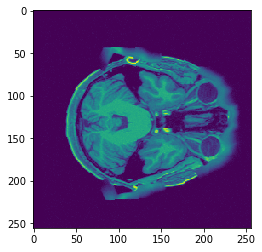

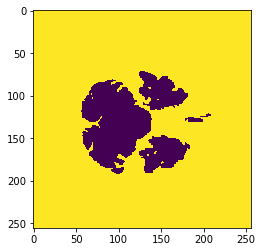

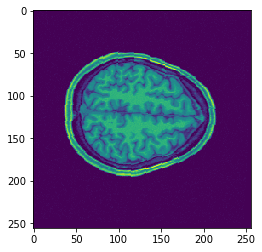

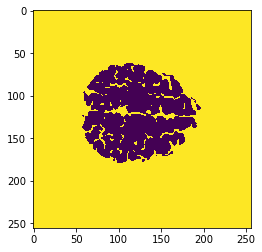

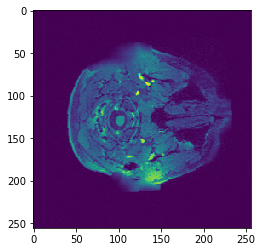

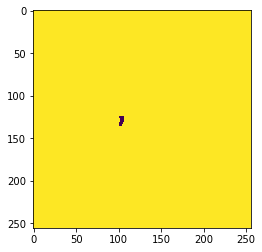

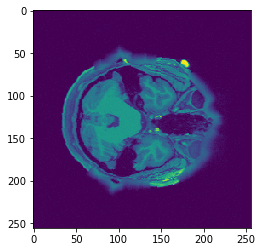

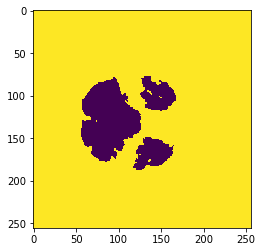

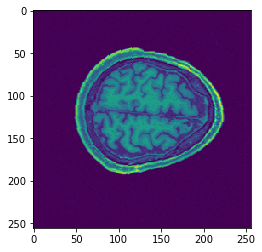

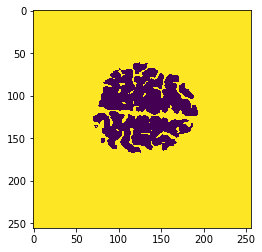

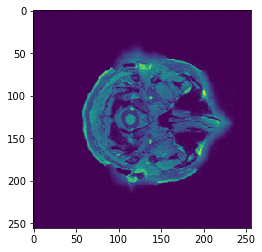

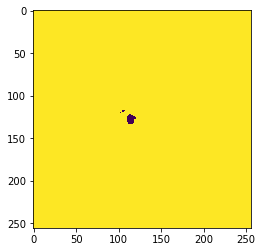

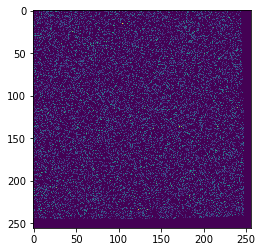

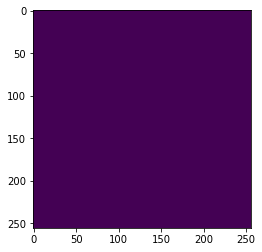

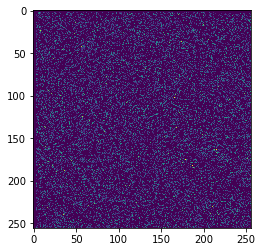

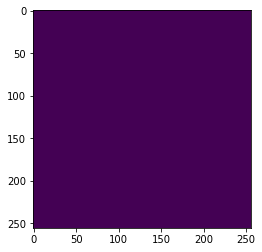

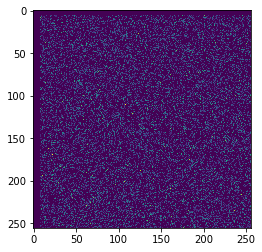

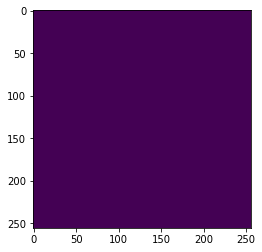

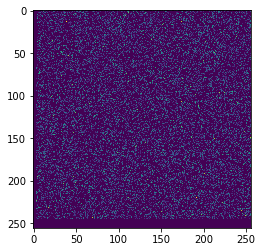

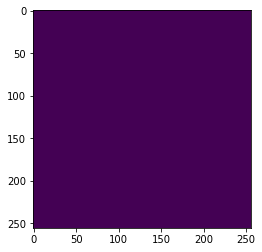

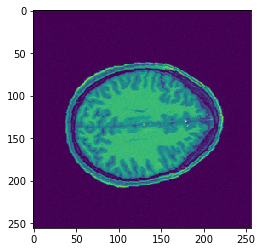

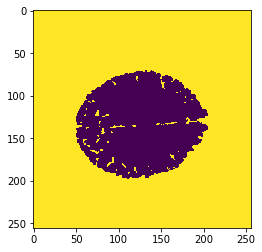

In [14]:
for i in range(28):
    plt.imshow(inputs['x'][i,0,:,:].numpy())
    plt.show()
    plt.imshow(inputs['y'][i,0,:,:].numpy())
    plt.show()

In [15]:
class Downsample_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(y, 2,stride = 2)
        
        return x, y

In [16]:
class Upsample_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(Upsample_block, self).__init__()
        self.transconv = nn.ConvTranspose2d(in_channels, out_channels, 4, padding = 1, stride = 2)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self,x, y):
        x = self.transconv(x)
        x = torch.cat((x,y),dim = 1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        return x

In [17]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Downsample_block(1,64)
        self.down2 = Downsample_block(64,128)
        self.down3 = Downsample_block(128,256)
        self.down4 = Downsample_block(256,512)
        self.conv1 = nn.Conv2d(512,1024, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.conv2 = nn.Conv2d(1024,1024,3, padding = 1)
        self.bn2 = nn.BatchNorm2d(1024)
        self.up4 = Upsample_block(1024,512)
        self.up3 = Upsample_block(512,256)
        self.up2 = Upsample_block(256,128)
        self.up1 = Upsample_block(128,64)
        self.outconv = nn.Conv2d(64,44, 1)
        
    def forward(self,x):
        x, y1 = self.down1(x)
        x, y2 = self.down2(x)
        x, y3 = self.down3(x)
        x, y4 = self.down4(x)
        x = F.dropout2d(F.relu(self.bn1(self.conv1(x))))
        x = F.dropout2d(F.relu(self.bn2(self.conv2(x))))
        x = self.up4(x, y4)
        x = self.up3(x, y3)
        x = self.up2(x, y2)
        x = self.up1(x, y1)
        x = self.outconv(x)
        
        return x

In [18]:
voxel_count = pd.read_csv('/cbi/hcp/hcp_seg/brain_segmentation/segment_counts.csv')

In [19]:
wts_num = np.mean(np.array(voxel_count.iloc[:,available_segments]),axis = 0)

In [20]:
wts_torch = Variable(torch.from_numpy(wts_num)).cuda()

In [21]:
def dice_loss_2(true1,scores1,mean, epsilon = 1e-4,p = 1):
    N, C, sh1, sh2 = true1.size()
    
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,1:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    try:
        true = torch.stack(true)
        scores = torch.stack(scores)
    except:
        return -1
    N, C, sh1, sh2 = true.size()
    
    
    preds = F.softmax(scores)
    true = true.view(N, C, -1)
    preds = preds.view(N, C, -1)
    wts = torch.sum(true, dim = 2) + epsilon
    mean = 1/torch.pow(mean,p)
    wts[:,:] = mean[None].repeat(N,1)
    wts = wts/(torch.sum(wts,dim = 1)[:,None])
    prod = torch.sum(true*preds,dim = 2)
    sum_tnp = torch.sum(true + preds, dim = 2)
    num = torch.sum(wts * prod, dim = 1)
    denom = torch.sum(wts * sum_tnp, dim = 1) + epsilon
    loss = 1 - 2*(num/denom)
    return torch.mean(loss)

In [22]:
def dice_score(true1,scores1, epsilon = 1e-7):
    N ,C, sh1, sh2 = true1.size()
    true = []
    scores = []
    for c in range(N):
        if not torch.sum(true1[c,1:,:,:])==0:
            true.append(true1[c,:,:,:])
            scores.append(scores1[c,:,:,:])
    try:
        true = torch.stack(true)
        scores = torch.stack(scores)
    except:
        return 0
    
    N, C, sh1, sh2 = true.size()
    
    true = true.view(N,C,-1)
    preds = F.softmax(scores)
    pred_class = (torch.max(preds, dim = 1)[1]).view(N,-1)
    class_score = [0]*44
    for i in range(44):
        class_score[i] = (pred_class == i).data.type(torch.cuda.FloatTensor)
    true = true.data.type(torch.cuda.FloatTensor)
    def numerator(truth,pred, idx):
        return(torch.sum(truth[:,idx,:] * pred,dim = 1)) + epsilon/2
    def denominator(truth,pred,idx):
        return(torch.sum(truth[:,idx,:]+pred,dim = 1)) + epsilon
    dice_class_score = [0]*44
    for i in range(44):
        dice_class_score[i] = torch.mean(2*(numerator(true,class_score[i],i))/(denominator(true,class_score[i],i)))
    return dice_class_score
    

In [23]:
import time
def train_model(model, optimizer,dataloader, data_sizes, batch_size, num_epochs = 100, verbose = False):
    since = time.time()
    best_loss = np.inf
    loss_hist = {'train':[],'validate':[]}
    dice_scores_of_all_class = [{'train':[],'validate':[]} for i in range(44)]    
    for i in range(num_epochs):
        for phase in ['train', 'validate']:
            running_loss = 0
            run_class_scores = [0]*44
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)
    
            for data in dataloader[phase]:
                optimizer.zero_grad()
                x = data['x']
                y = data['y']
                x = Variable(x).type(torch.FloatTensor).cuda()
                y = Variable(y).type(torch.FloatTensor).cuda()
                
                output = model(x)
                loss = dice_loss_2(y, output,wts_torch)
                if loss==-1:
                    continue
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0] * batch_size
                dice_score_batch = dice_score(y,output)

                for j in range(44):
                    run_class_scores[j] = run_class_scores[j] + dice_score_batch[j] * batch_size
            epoch_loss = running_loss/data_sizes[phase]
            loss_hist[phase].append(epoch_loss.item()) 
            for j in range(44):
                score = run_class_scores[j]/data_sizes[phase]
                dice_scores_of_all_class[j][phase].append(score.to(torch.device("cpu")).numpy())
            if verbose or i%1 == 0:
                print('Epoch: {}, Phase: {}, epoch loss: {:.4f}'.format(i,phase,epoch_loss))
                print('-'*10)
            
        if phase == 'validate' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict() 
        # print(i)
    print('-'*50)    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val dice loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, loss_hist, dice_scores_of_all_class

In [24]:
model = Unet().cuda()
model = nn.DataParallel(model)
criterion = dice_loss_2

optimizer = optim.Adam(model.parameters(),lr = 5e-4)

In [25]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,28,
                                                                num_epochs = 20, verbose = True)

Epoch: 0, Phase: train, epoch loss: 1.0080
----------
Epoch: 0, Phase: validate, epoch loss: 1.0080
----------
Epoch: 1, Phase: train, epoch loss: 1.0079
----------
Epoch: 1, Phase: validate, epoch loss: 1.0079
----------
Epoch: 2, Phase: train, epoch loss: 1.0079
----------
Epoch: 2, Phase: validate, epoch loss: 1.0080
----------
Epoch: 3, Phase: train, epoch loss: 1.0078
----------
Epoch: 3, Phase: validate, epoch loss: 1.0079
----------
Epoch: 4, Phase: train, epoch loss: 1.0075
----------
Epoch: 4, Phase: validate, epoch loss: 1.0078
----------
Epoch: 5, Phase: train, epoch loss: 1.0068
----------
Epoch: 5, Phase: validate, epoch loss: 1.0074
----------
Epoch: 6, Phase: train, epoch loss: 1.0020
----------
Epoch: 6, Phase: validate, epoch loss: 0.9918
----------
Epoch: 7, Phase: train, epoch loss: 0.9644
----------
Epoch: 7, Phase: validate, epoch loss: 0.9585
----------
Epoch: 8, Phase: train, epoch loss: 0.8308
----------
Epoch: 8, Phase: validate, epoch loss: 0.8064
----------
E

In [30]:
optimizer = optim.Adam(model.parameters(),lr = 5e-5)

In [32]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,28,
                                                                num_epochs = 20, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.6816
----------
Epoch: 0, Phase: validate, epoch loss: 0.6593
----------
Epoch: 1, Phase: train, epoch loss: 0.6798
----------
Epoch: 1, Phase: validate, epoch loss: 0.6823
----------
Epoch: 2, Phase: train, epoch loss: 0.6756
----------
Epoch: 2, Phase: validate, epoch loss: 0.6638
----------
Epoch: 3, Phase: train, epoch loss: 0.6803
----------
Epoch: 3, Phase: validate, epoch loss: 0.6673
----------
Epoch: 4, Phase: train, epoch loss: 0.6799
----------
Epoch: 4, Phase: validate, epoch loss: 0.6596
----------
Epoch: 5, Phase: train, epoch loss: 0.6798
----------
Epoch: 5, Phase: validate, epoch loss: 0.6643
----------
Epoch: 6, Phase: train, epoch loss: 0.6773
----------
Epoch: 6, Phase: validate, epoch loss: 0.6668
----------
Epoch: 7, Phase: train, epoch loss: 0.6792
----------
Epoch: 7, Phase: validate, epoch loss: 0.6659
----------
Epoch: 8, Phase: train, epoch loss: 0.6789
----------
Epoch: 8, Phase: validate, epoch loss: 0.6677
----------
E

In [40]:
optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [41]:
model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,28,
                                                                num_epochs = 10, verbose = True)

Epoch: 0, Phase: train, epoch loss: 0.6732
----------
Epoch: 0, Phase: validate, epoch loss: 0.6491
----------
Epoch: 1, Phase: train, epoch loss: 0.6750
----------
Epoch: 1, Phase: validate, epoch loss: 0.6580
----------
Epoch: 2, Phase: train, epoch loss: 0.6755
----------
Epoch: 2, Phase: validate, epoch loss: 0.6509
----------
Epoch: 3, Phase: train, epoch loss: 0.6774
----------
Epoch: 3, Phase: validate, epoch loss: 0.6528
----------
Epoch: 4, Phase: train, epoch loss: 0.6794
----------
Epoch: 4, Phase: validate, epoch loss: 0.6504
----------
Epoch: 5, Phase: train, epoch loss: 0.6736
----------
Epoch: 5, Phase: validate, epoch loss: 0.6561
----------
Epoch: 6, Phase: train, epoch loss: 0.6766
----------
Epoch: 6, Phase: validate, epoch loss: 0.6511
----------
Epoch: 7, Phase: train, epoch loss: 0.6791
----------
Epoch: 7, Phase: validate, epoch loss: 0.6522
----------
Epoch: 8, Phase: train, epoch loss: 0.6779
----------
Epoch: 8, Phase: validate, epoch loss: 0.6561
----------
E

In [43]:
torch.save(model.state_dict(), "model8")

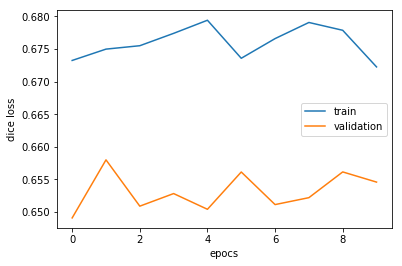

In [44]:
plt.plot(loss_hist["train"],label="train")
plt.plot(loss_hist["validate"],label = "validation")
plt.ylabel("dice loss")
plt.xlabel("epocs")
plt.legend()
plt.show()

In [45]:
# plt.plot(loss_hist["train"],label="train")
# plt.plot(loss_hist["validate"],label = "validation")
# plt.ylabel("dice loss")
# plt.xlabel("epocs")
# plt.legend()
# plt.show()

In [46]:
# optimizer = optim.Adam(model.parameters(),lr = 5e-6)

In [47]:
# model, loss_hist, dice_hist = train_model(model, optimizer,dataloader,data_sizes,12,
#                                                                 num_epochs = 10, verbose = True)

In [83]:
# pickling(dice_hist,"model1_dice_hist")

In [48]:
# data = next(iter(dataloader["validate"]))

In [142]:
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)

In [26]:
def visualize1(image):
    p = F.softmax(image)
    p_maxim = torch.max(p, dim=0)[1]
    img = []
    for seg in range(44):
        masked = (p_maxim==seg).data.type(torch.cuda.FloatTensor)
        img.append(masked)
    #plt.title(title)
    #plt.imshow(masked[:,:].cpu().numpy())
    #print(torch.stack(img).size())
    return torch.stack(img).resize(44,1,256,256).cpu()

In [27]:
# abc = data['y'][5,:,:,:]
# bcd = abc.resize(46,1,256,256)
# show(make_grid(bcd,padding=10,pad_value=1)) 

----------------------------------------------------------------------------------------------------
Ground Truth


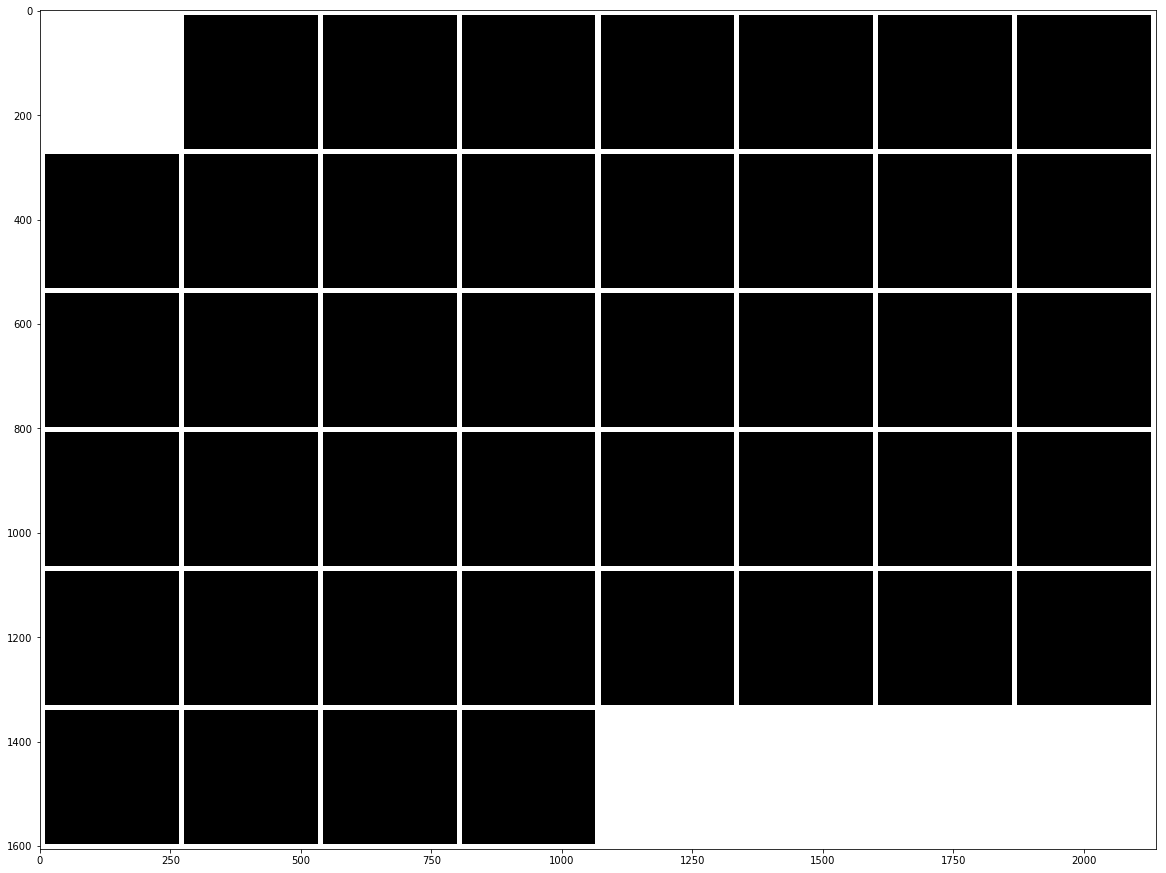

----------------------------------------------------------------------------------------------------
Prediction


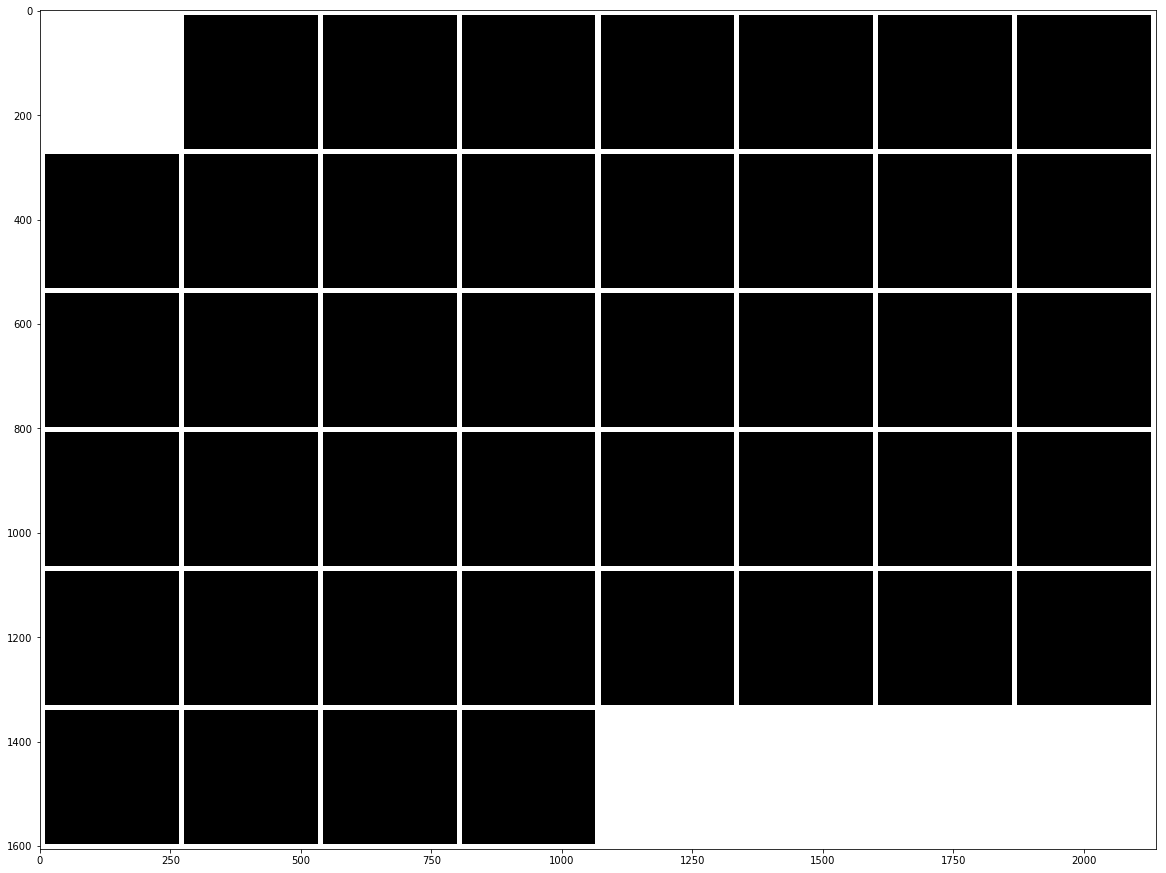

----------------------------------------------------------------------------------------------------
Ground Truth


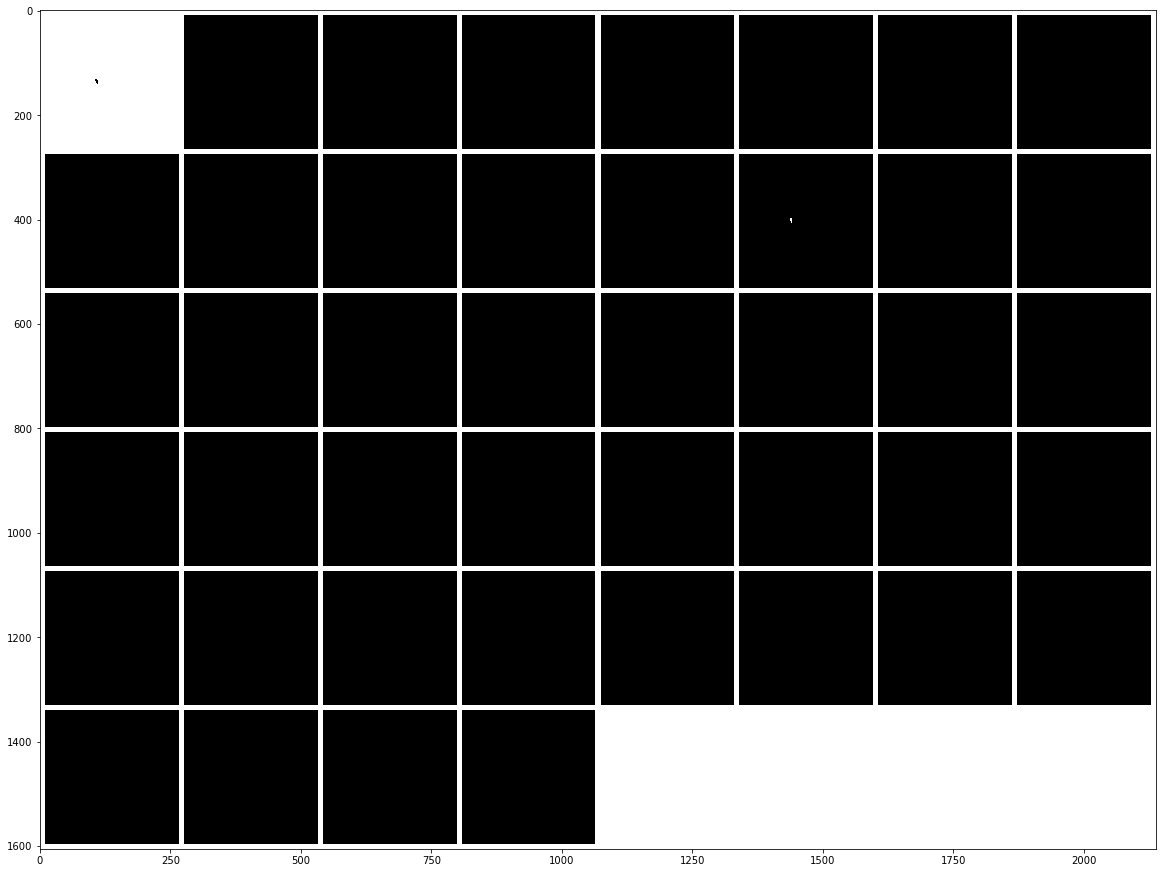

----------------------------------------------------------------------------------------------------
Prediction


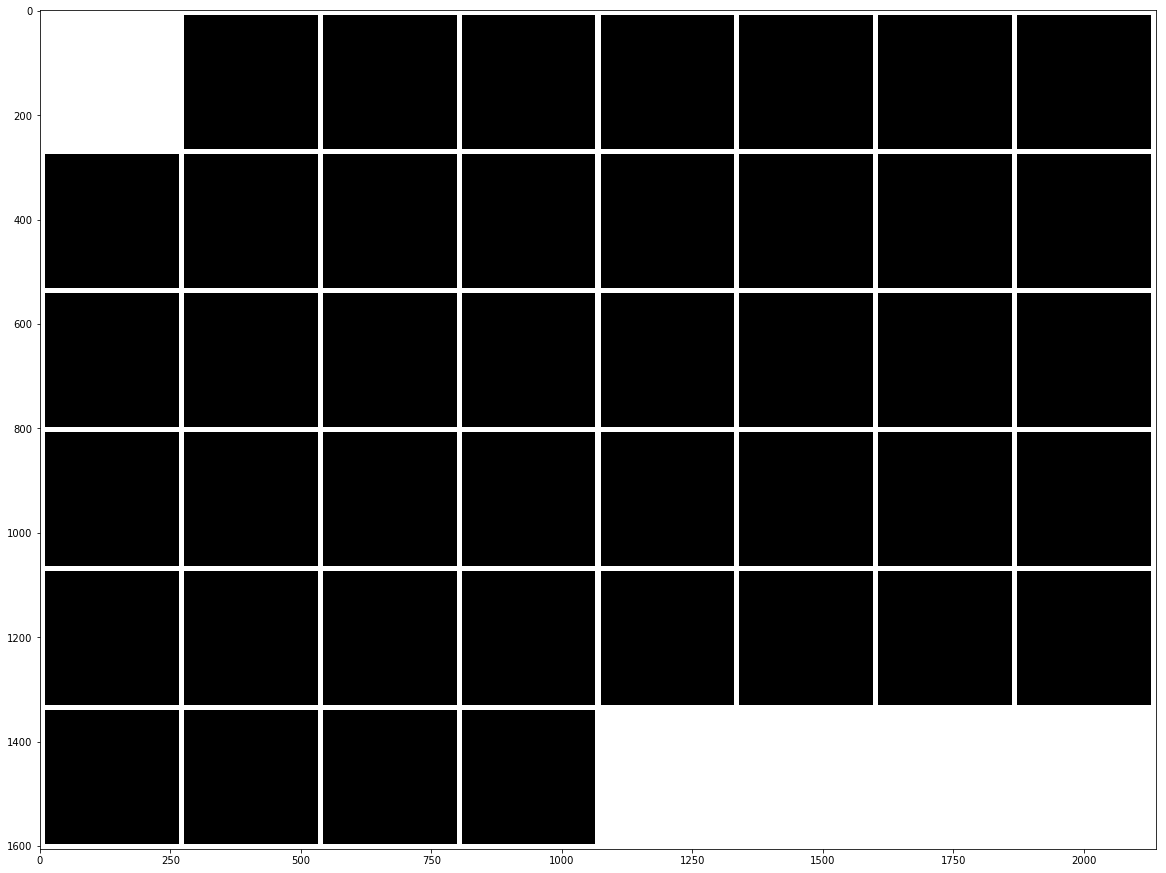

----------------------------------------------------------------------------------------------------
Ground Truth


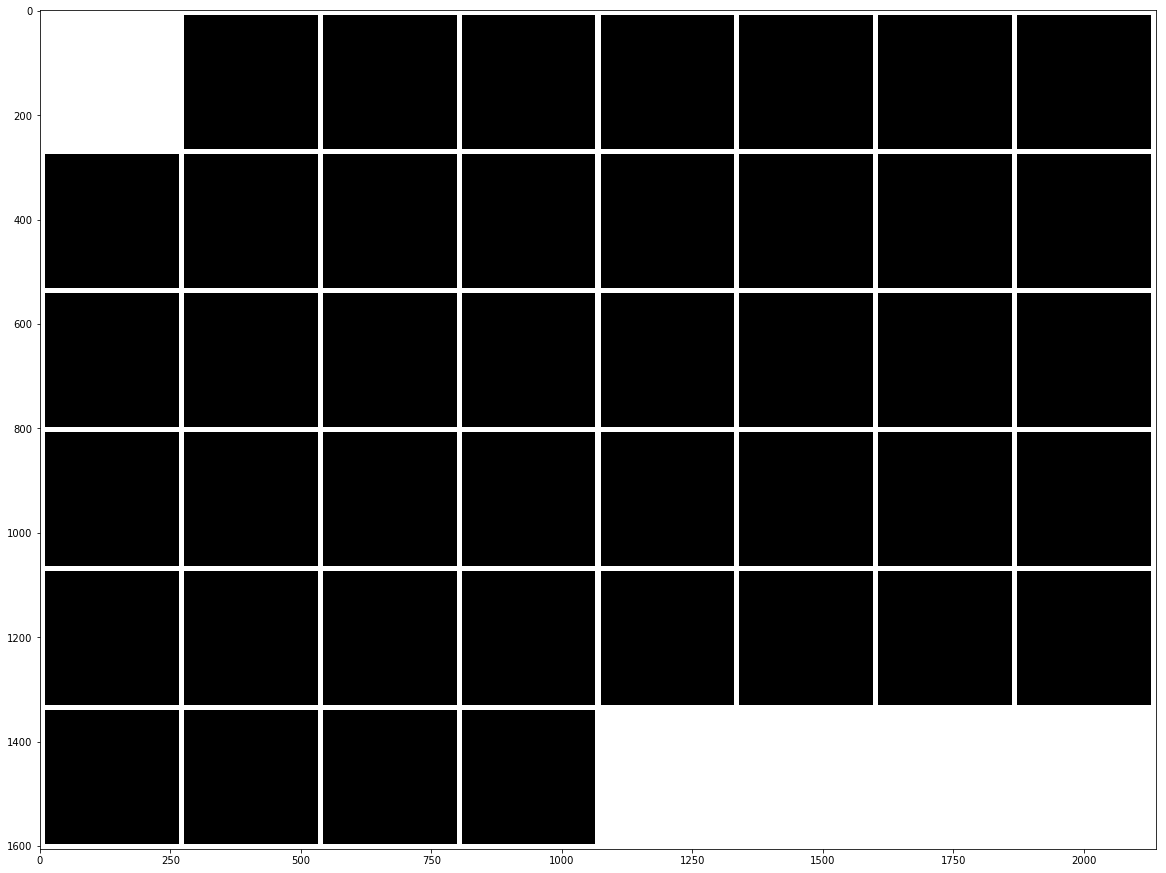

----------------------------------------------------------------------------------------------------
Prediction


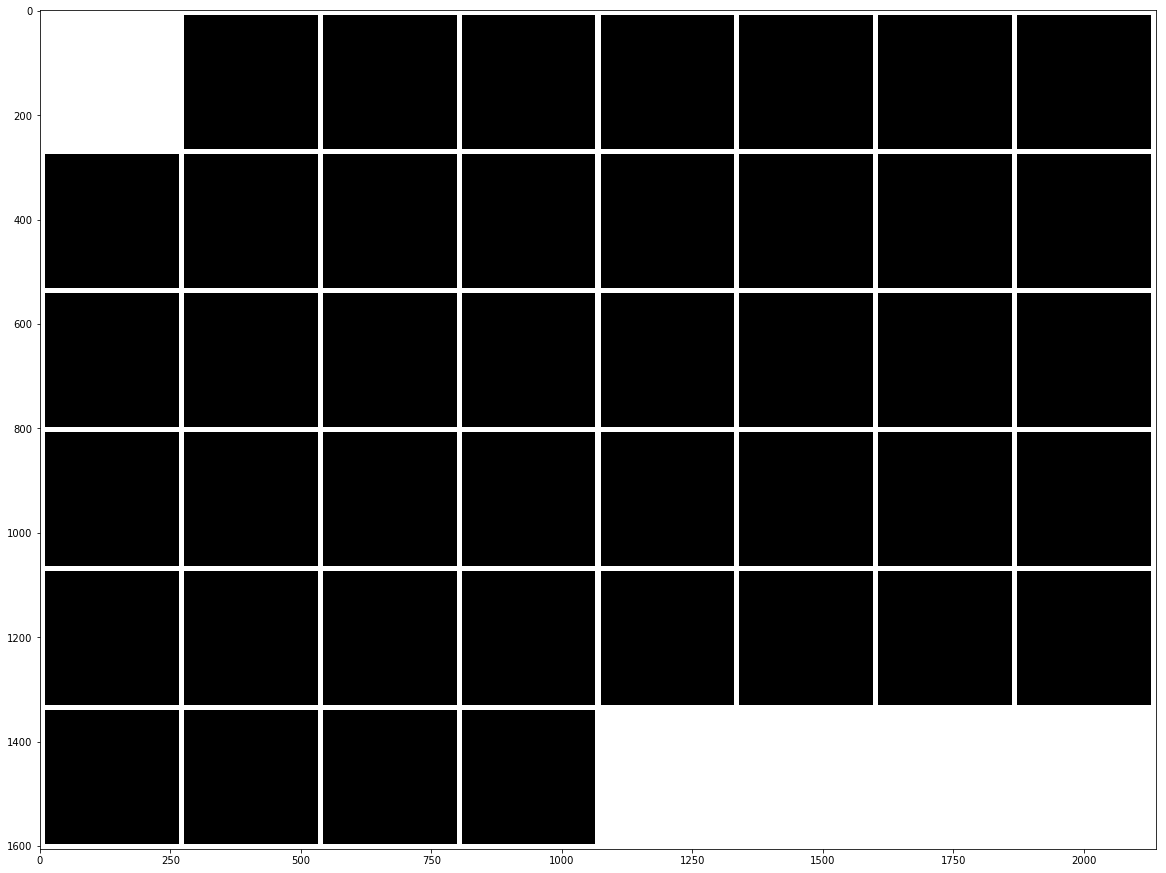

----------------------------------------------------------------------------------------------------
Ground Truth


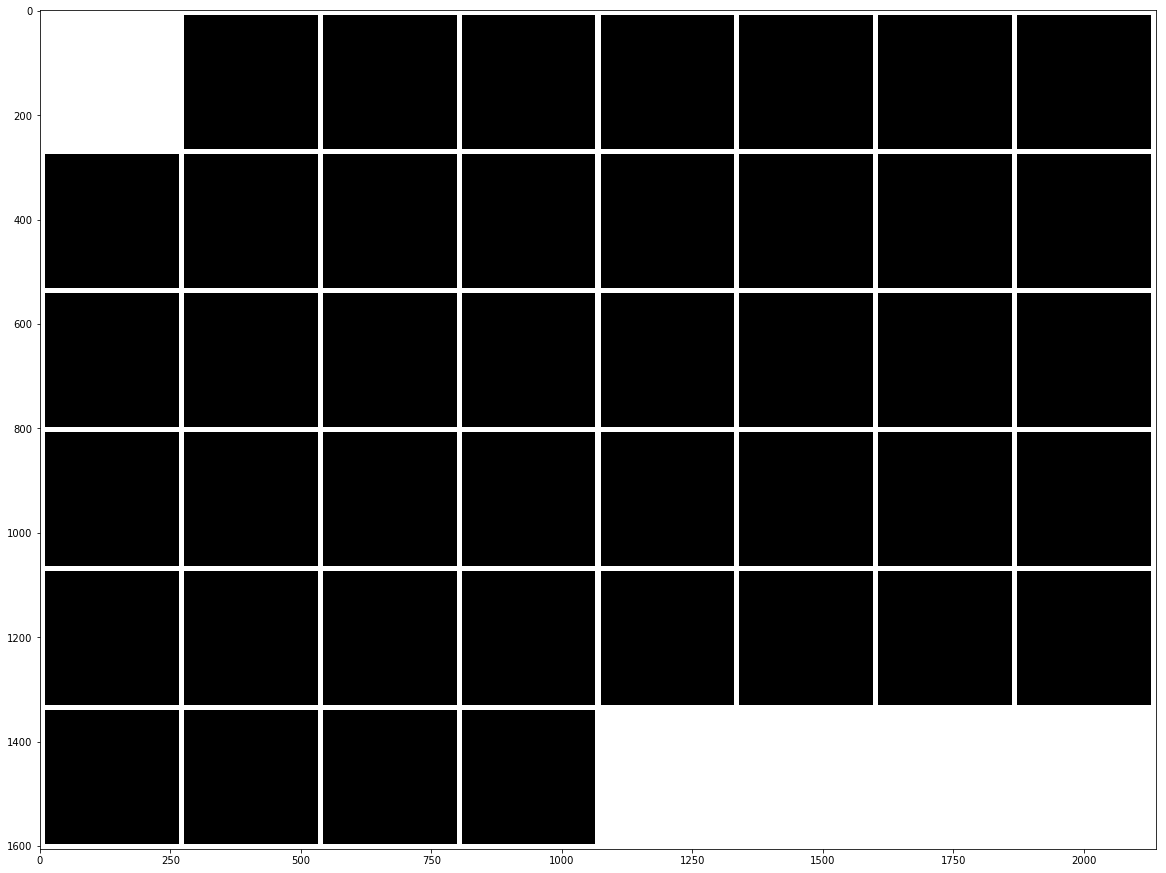

----------------------------------------------------------------------------------------------------
Prediction


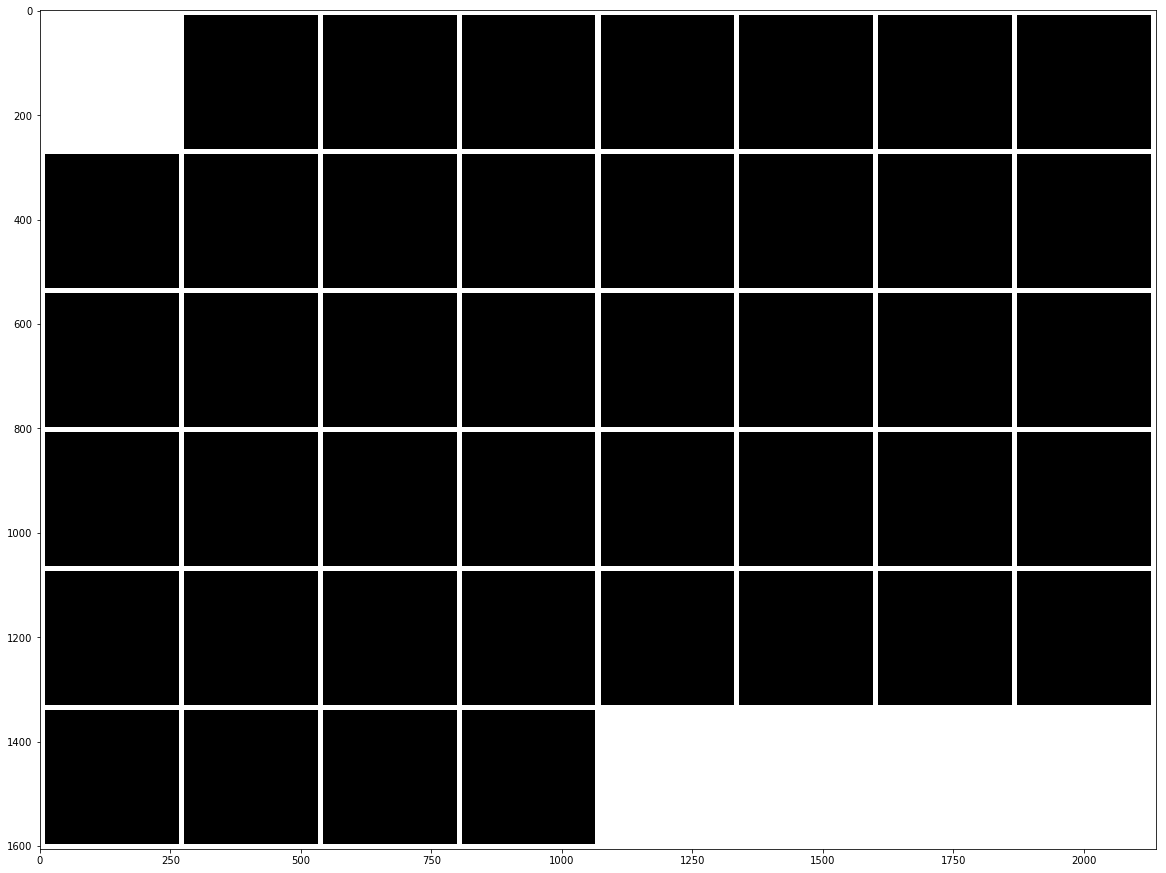

----------------------------------------------------------------------------------------------------
Ground Truth


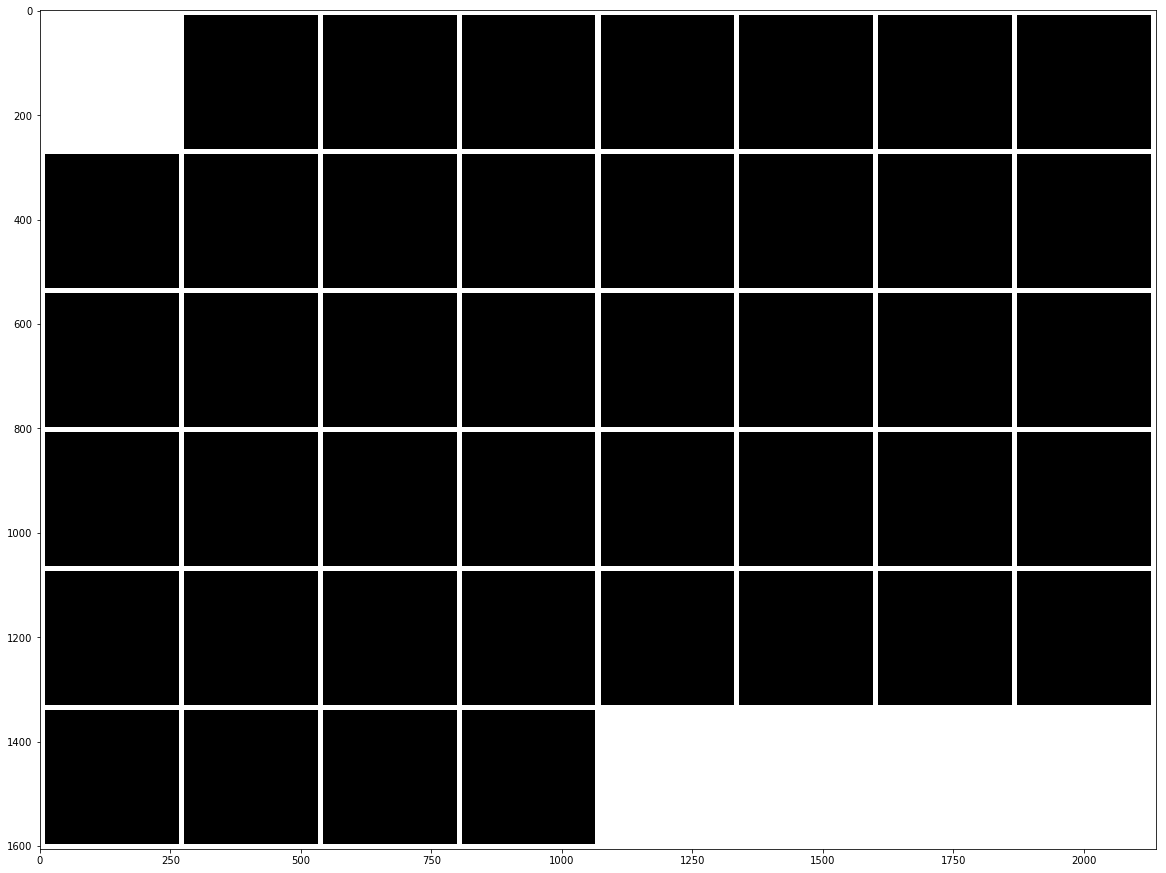

----------------------------------------------------------------------------------------------------
Prediction


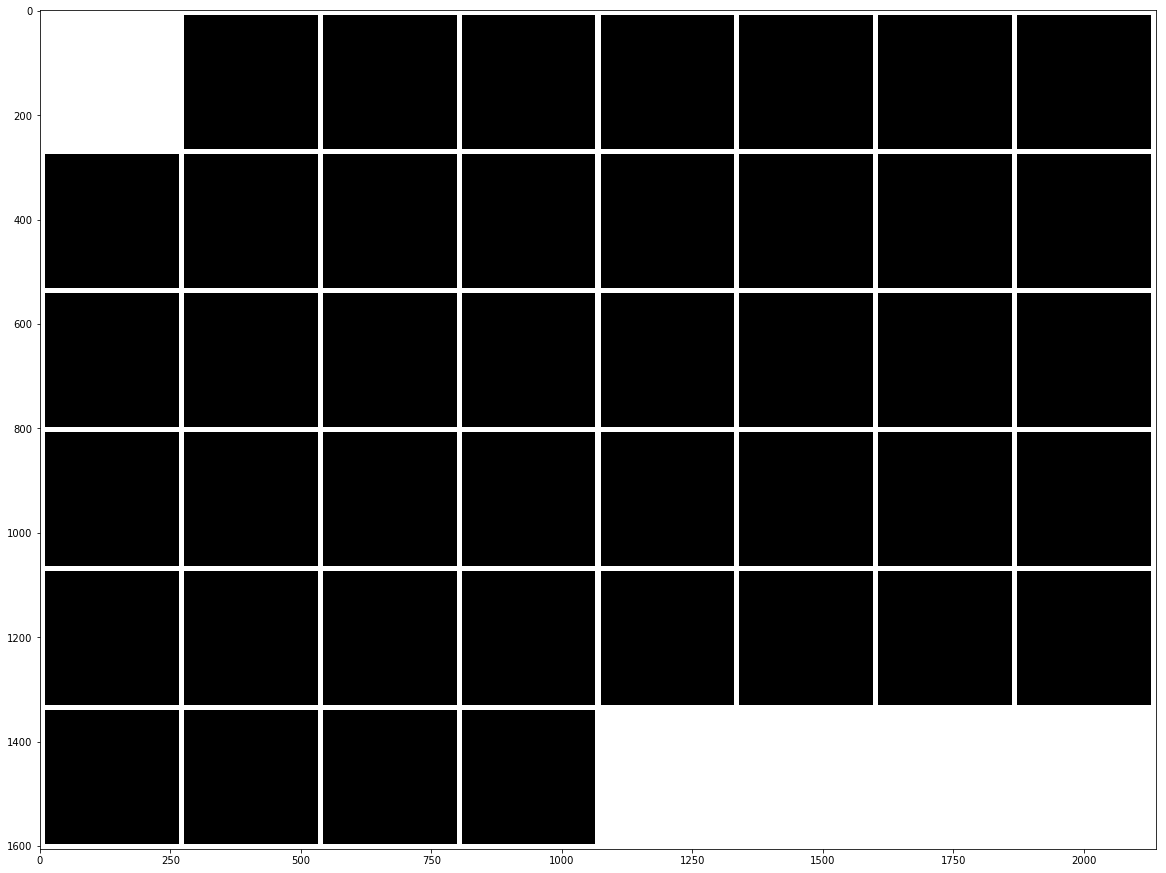

----------------------------------------------------------------------------------------------------
Ground Truth


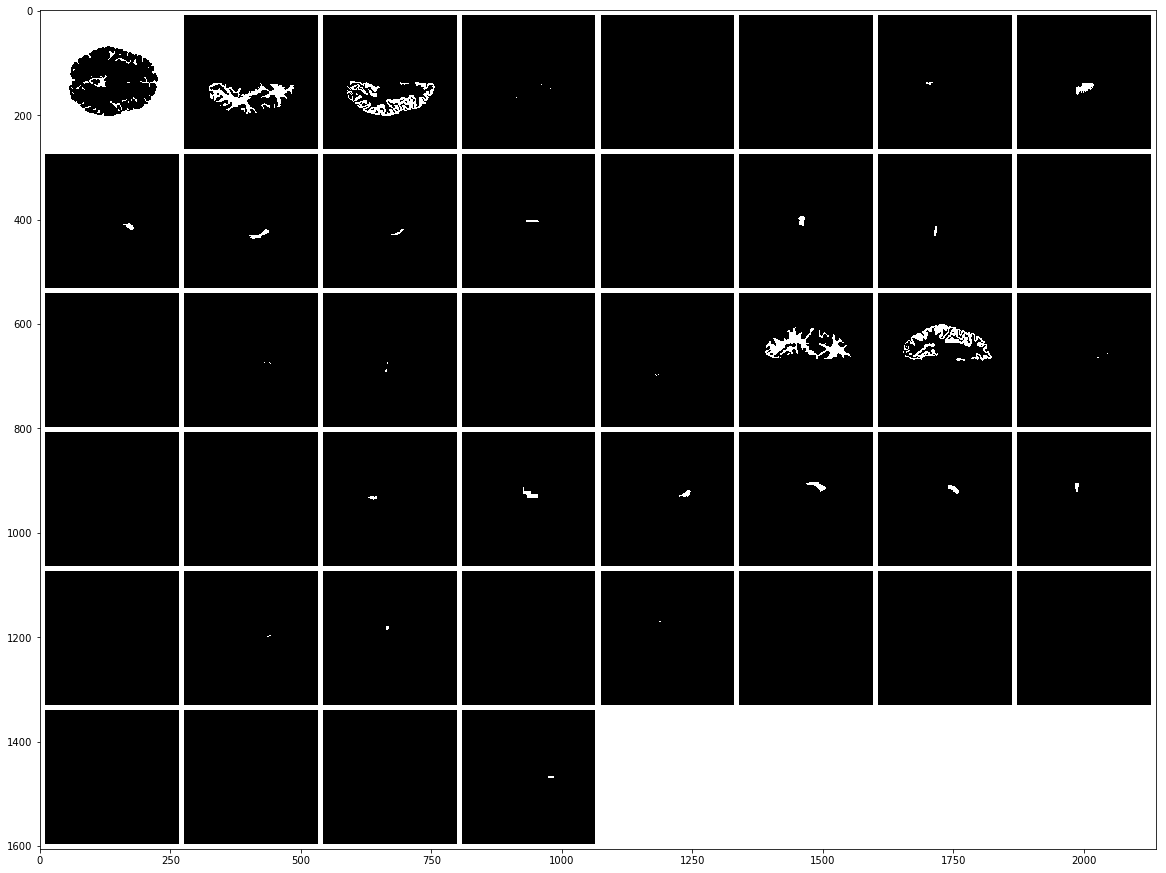

----------------------------------------------------------------------------------------------------
Prediction


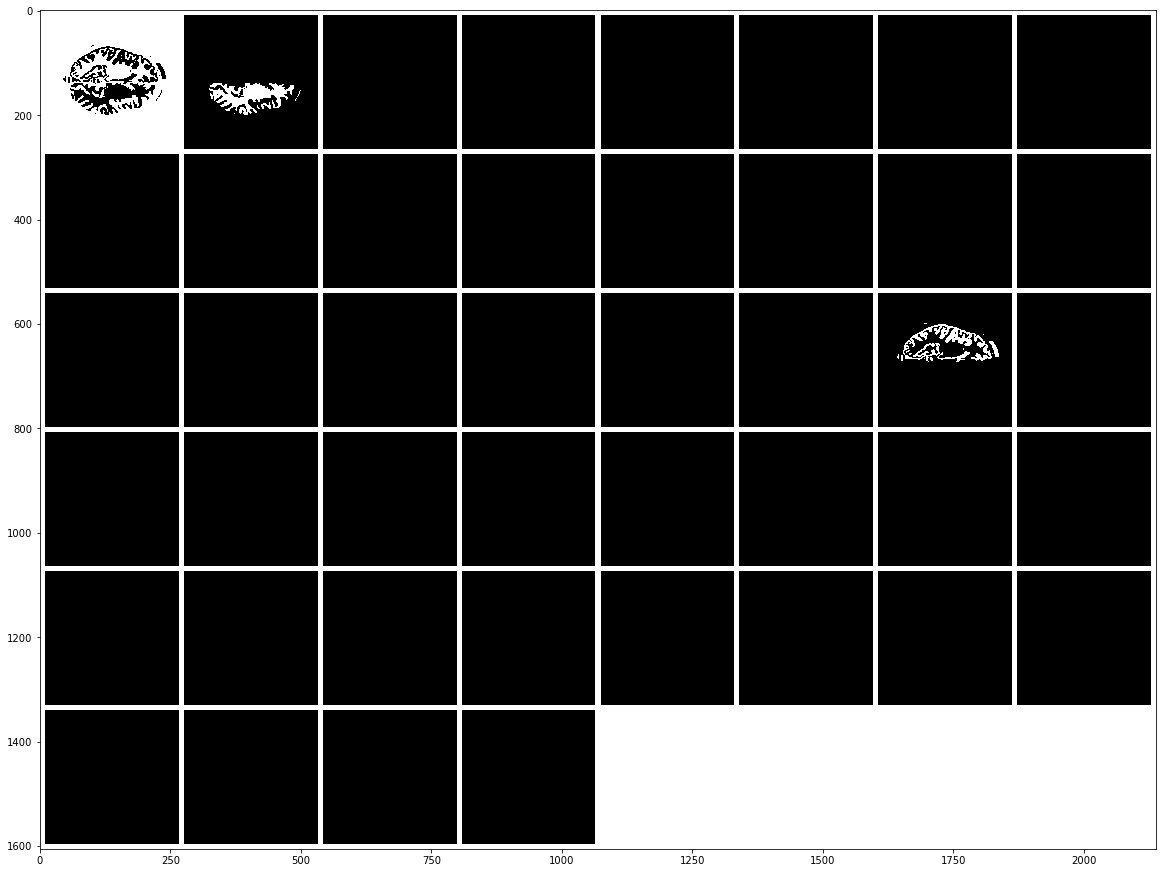

----------------------------------------------------------------------------------------------------
Ground Truth


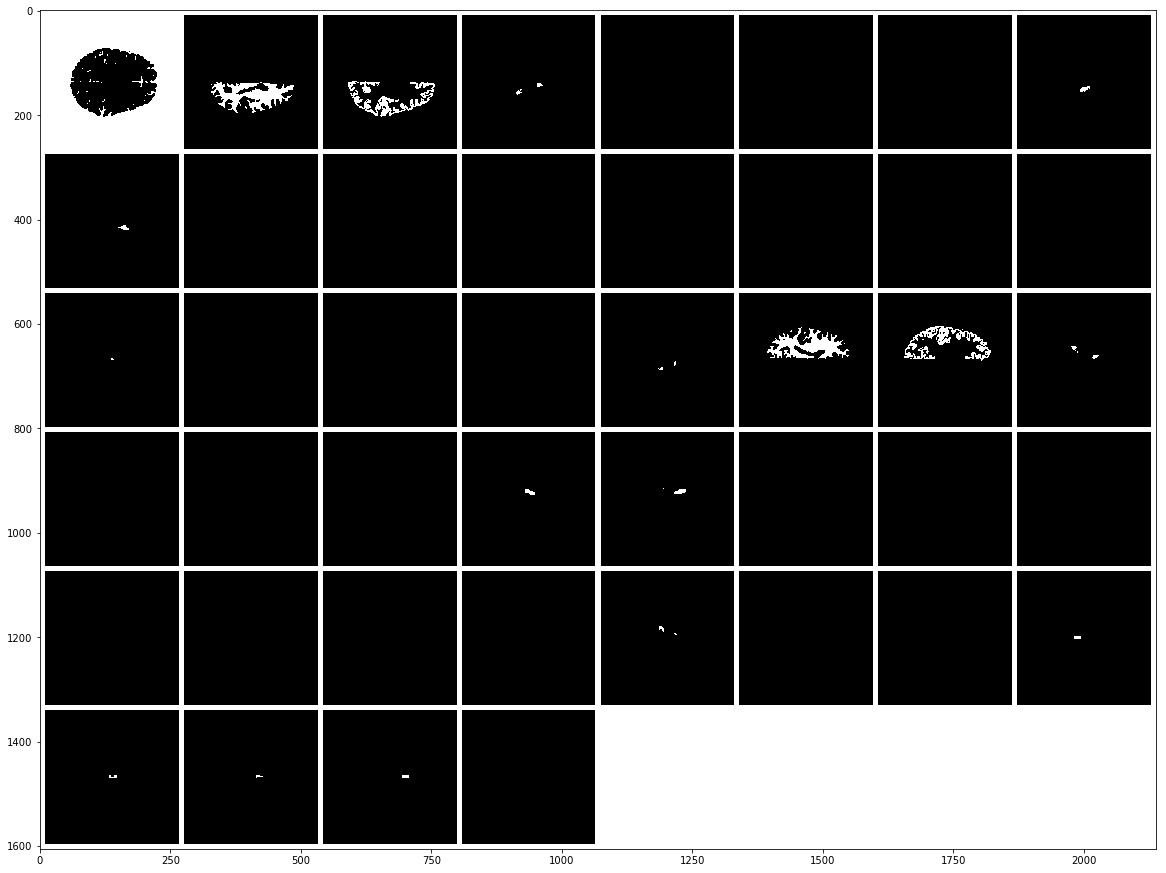

----------------------------------------------------------------------------------------------------
Prediction


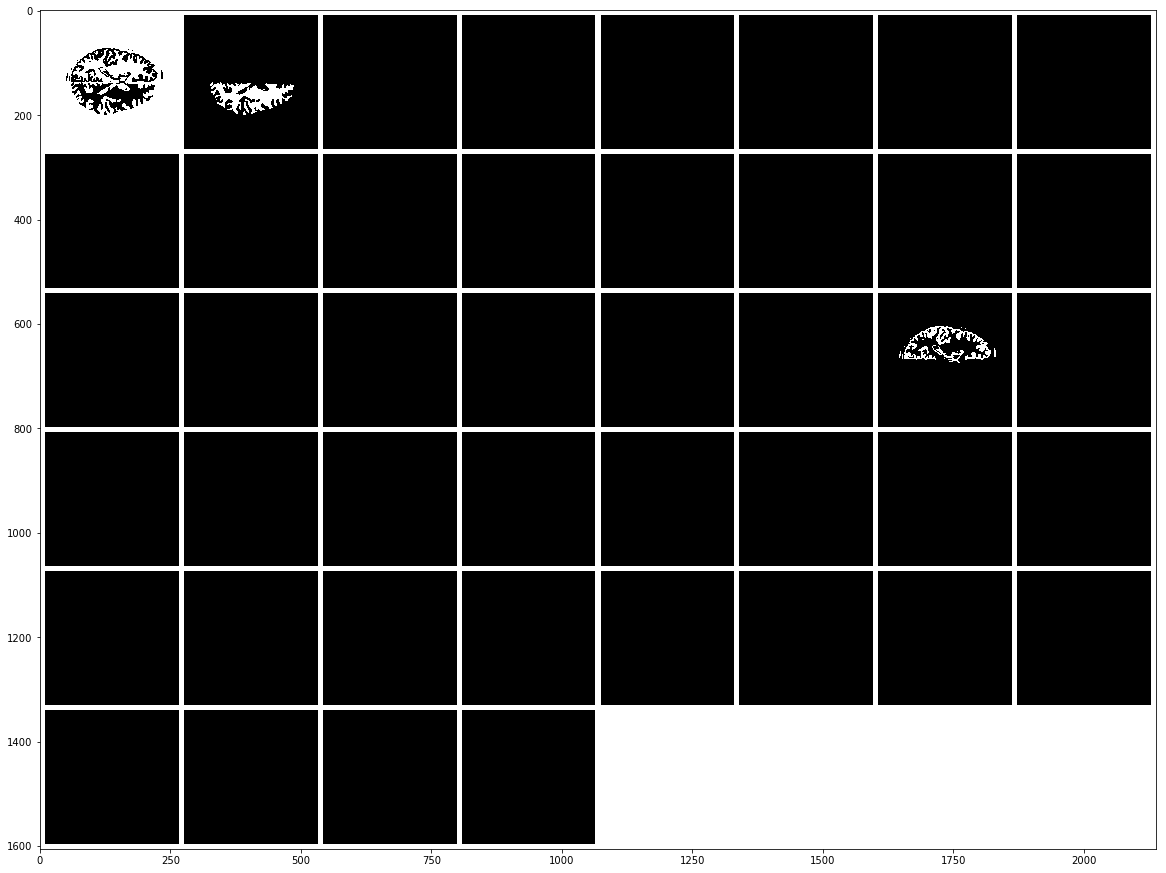

----------------------------------------------------------------------------------------------------
Ground Truth


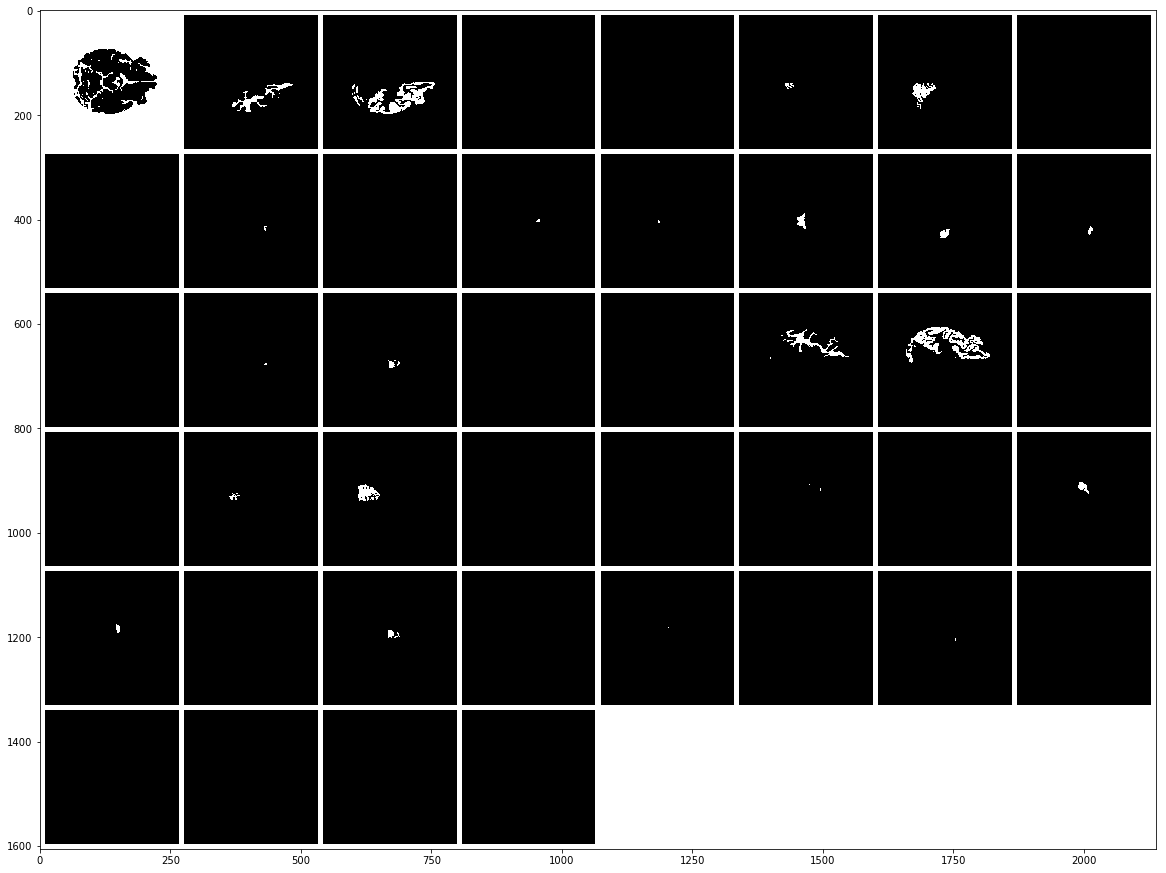

----------------------------------------------------------------------------------------------------
Prediction


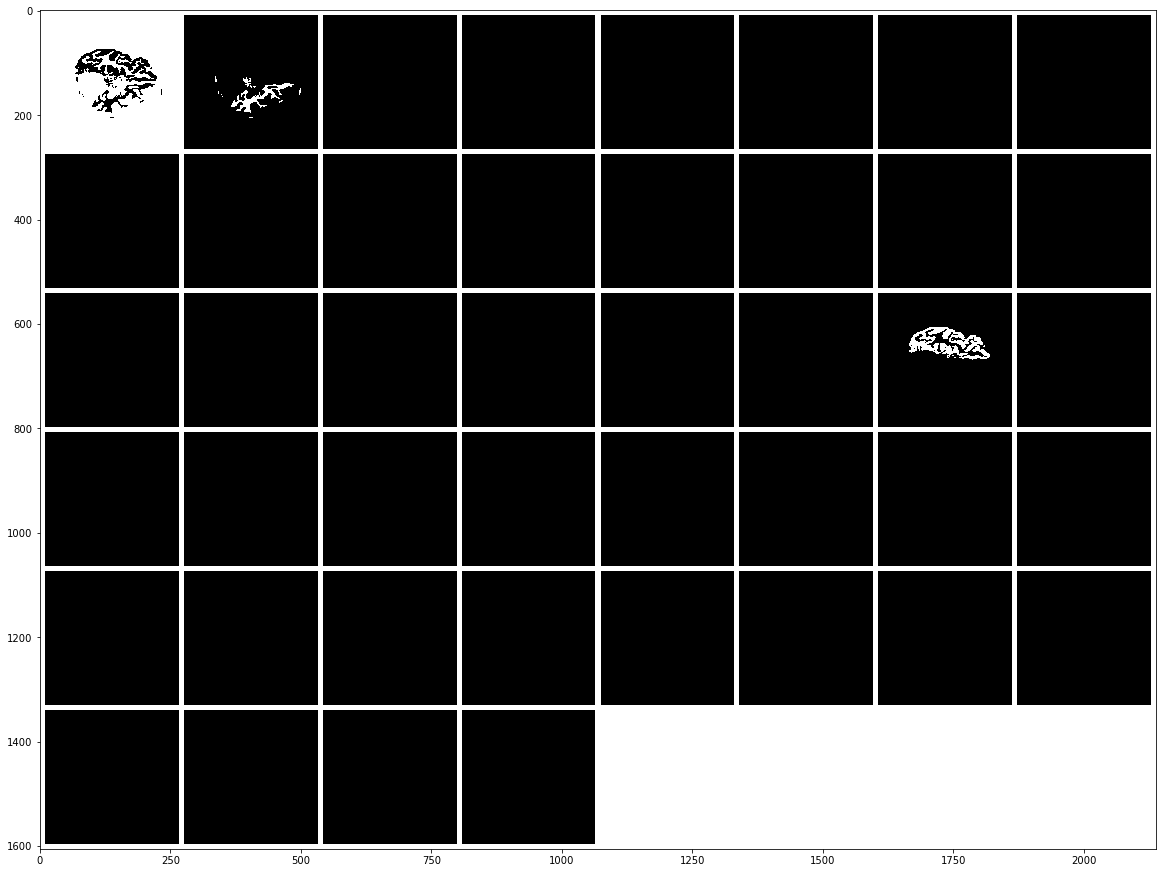

----------------------------------------------------------------------------------------------------
Ground Truth


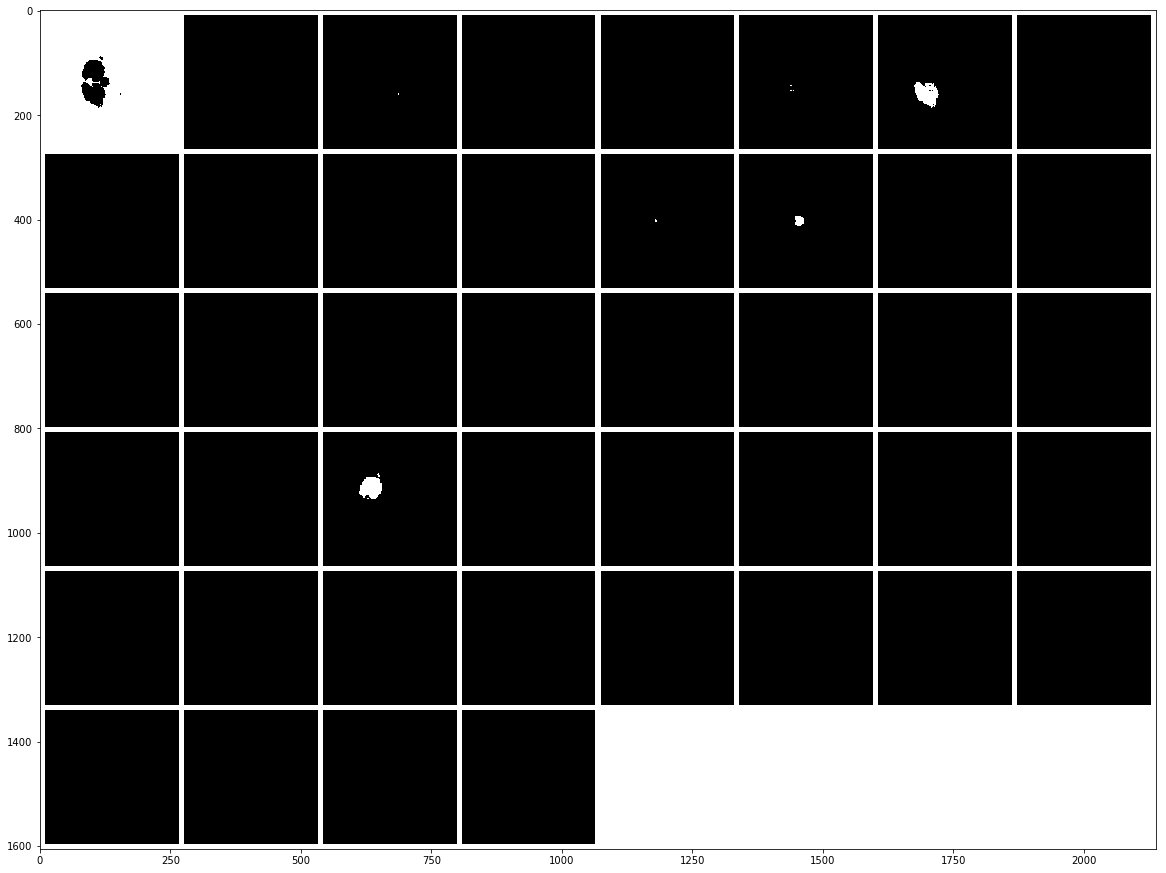

----------------------------------------------------------------------------------------------------
Prediction


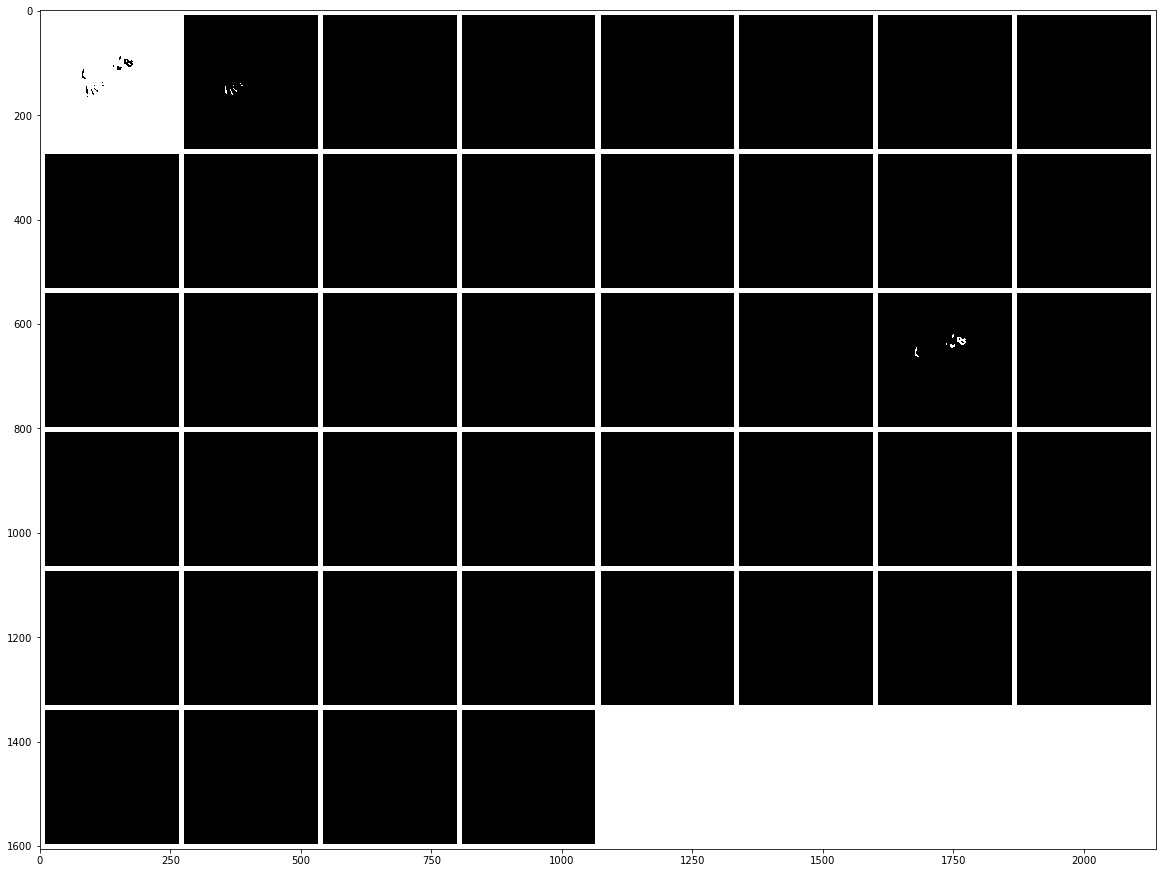

----------------------------------------------------------------------------------------------------
Ground Truth


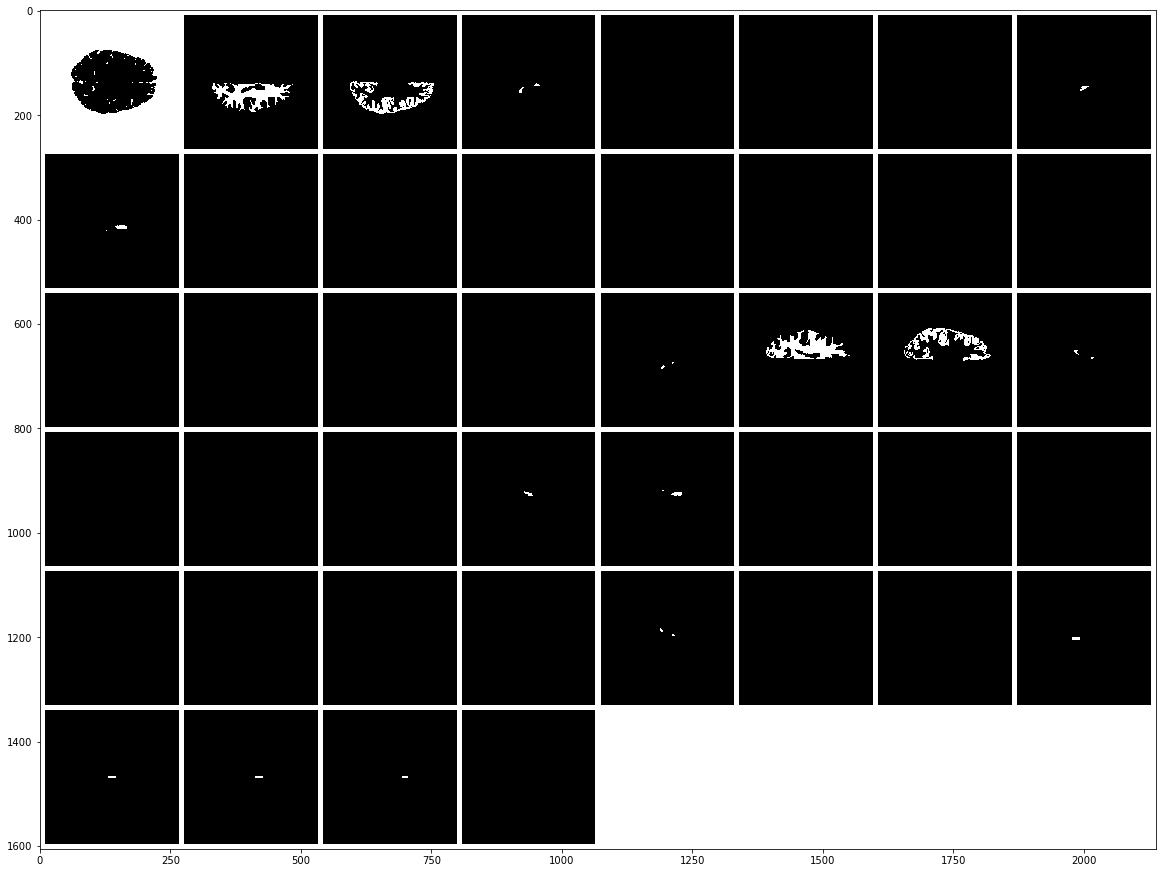

----------------------------------------------------------------------------------------------------
Prediction


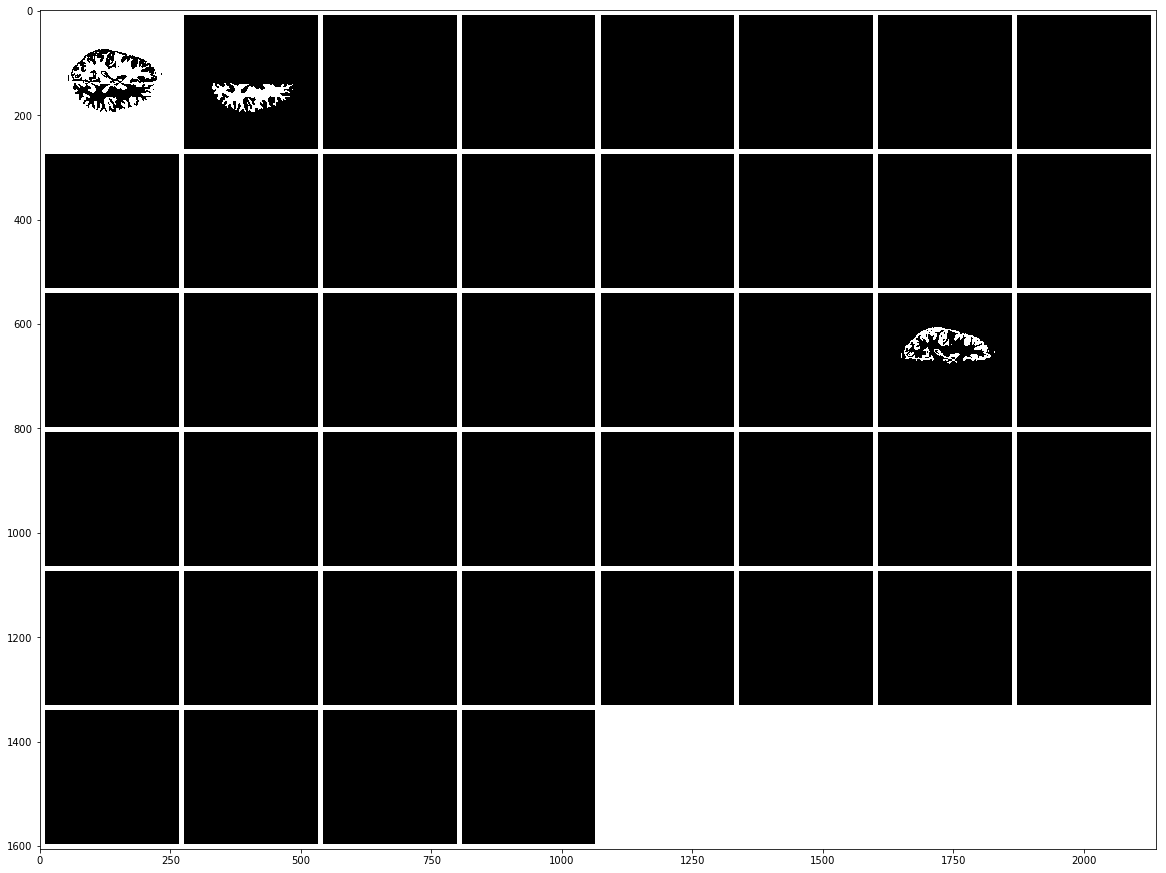

----------------------------------------------------------------------------------------------------
Ground Truth


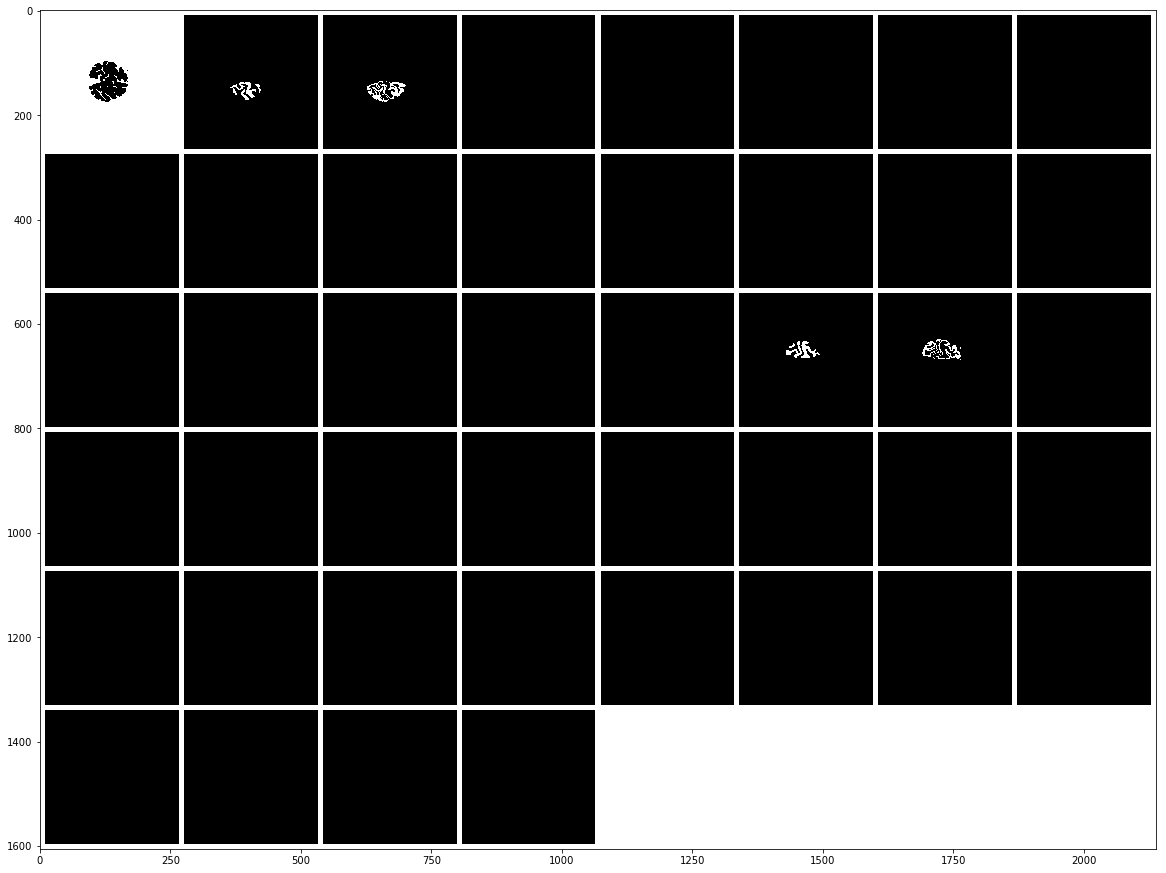

----------------------------------------------------------------------------------------------------
Prediction


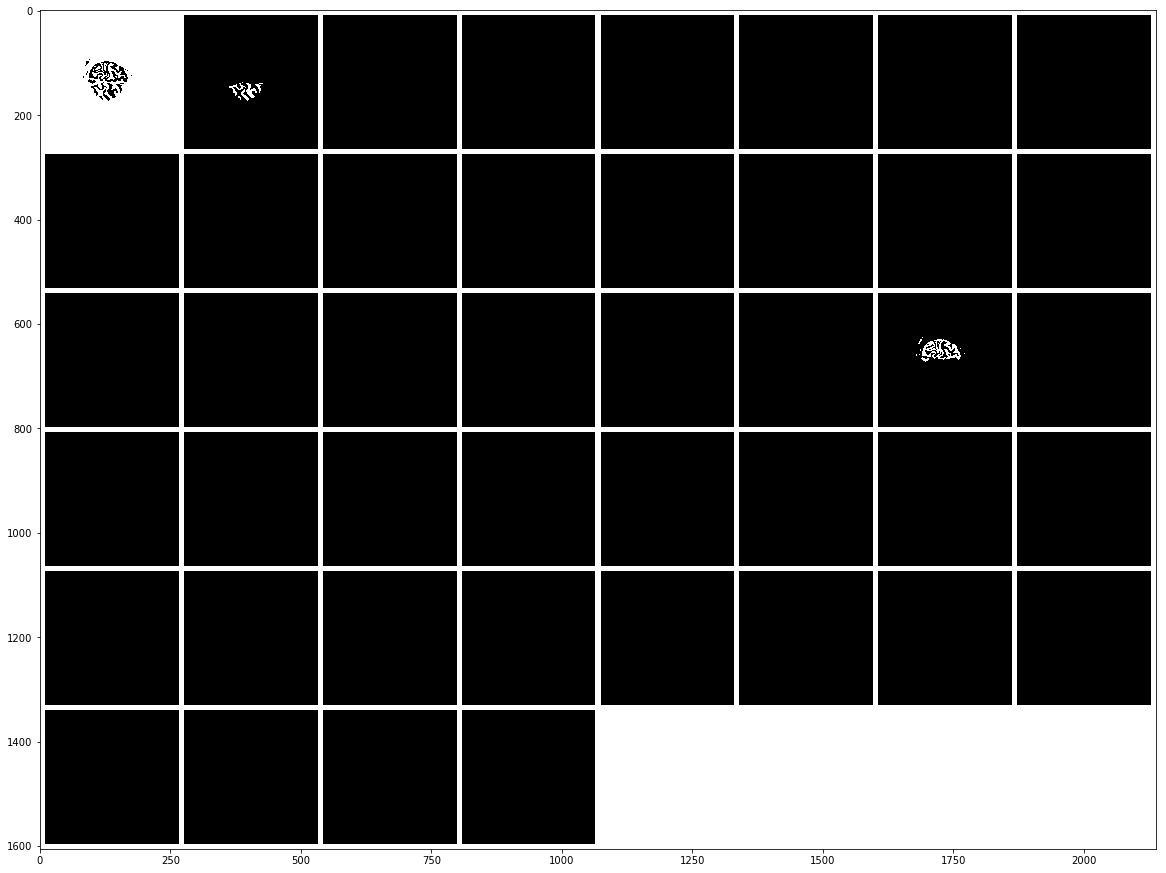

In [42]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(44,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    

In [35]:
names = []
for i in range(20):
    name = "epoch"+str(i)
    names.append(name)

In [36]:
train_dice_scores = pd.DataFrame(columns=names)
val_dice_scores = pd.DataFrame(columns=names)

In [37]:
for i in range(44):
    class_i_train = dice_hist[i]['train']
    class_i_val = dice_hist[i]['validate']
    #print(len(class_i_train))
    #print(len(class_i_val))
    train_dice_scores.loc[i] = class_i_train
    val_dice_scores.loc[i] = class_i_val

In [38]:
train_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11,epoch12,epoch13,epoch14,epoch15,epoch16,epoch17,epoch18,epoch19
0,0.9636558,0.9630204,0.9632979,0.9631515,0.9629432,0.96274143,0.96299404,0.96246374,0.9629172,0.96318346,0.9626693,0.96289396,0.96303046,0.9629152,0.9629771,0.96331567,0.96253943,0.9629248,0.96376914,0.9631966
1,0.7134561,0.7358512,0.73659974,0.7395613,0.7338669,0.7412234,0.7446876,0.7464259,0.70882577,0.7279564,0.74138457,0.73015004,0.7372167,0.7382368,0.73885596,0.7462738,0.7463765,0.7340476,0.72701836,0.7381199
2,0.149334,0.15506665,0.15282387,0.15232861,0.14905284,0.15248398,0.15286617,0.15070297,0.15126392,0.15112817,0.15086432,0.1523354,0.1506007,0.15258333,0.15225875,0.1536831,0.1542094,0.15079896,0.15048316,0.15325795
3,0.7857156,0.7909371,0.7941369,0.78711987,0.7856032,0.7891514,0.79204893,0.78617597,0.7889858,0.7886885,0.7901546,0.79125255,0.78930664,0.78599846,0.7890985,0.7896458,0.7921895,0.7855541,0.78866017,0.7909206
4,0.9175685,0.9170531,0.9182999,0.91952837,0.91730183,0.9171084,0.917932,0.92069906,0.9171902,0.91961205,0.9189999,0.9165543,0.9187305,0.9201871,0.9211561,0.9212697,0.9148216,0.92021185,0.9166767,0.91900843
5,0.69363916,0.69328004,0.69443053,0.69586027,0.6959628,0.69390464,0.6956426,0.6986193,0.69060165,0.6900759,0.68992436,0.6899725,0.6898771,0.69607747,0.6920948,0.6963764,0.69063485,0.6952916,0.6919973,0.68894887
6,0.56212246,0.5590607,0.5630556,0.56336844,0.56489456,0.5621236,0.56068873,0.56539613,0.55939054,0.5611999,0.55835813,0.55415434,0.5589024,0.563493,0.5588049,0.5640233,0.55934536,0.5643515,0.5570537,0.5595462
7,0.820346,0.8270093,0.827875,0.8261504,0.82139266,0.8248112,0.8276468,0.8207772,0.8268244,0.8281541,0.8242533,0.82478565,0.82390964,0.8218886,0.8261712,0.8280273,0.82766145,0.8225777,0.8247734,0.82760197
8,0.7745386,0.77824104,0.7811186,0.77741444,0.7730737,0.7764044,0.7781935,0.77328646,0.77725834,0.7772454,0.77661645,0.77704614,0.7768875,0.7745571,0.77743196,0.7775069,0.7807238,0.7748841,0.777563,0.77852297
9,0.82694495,0.83088505,0.8314581,0.82884926,0.82823765,0.8340046,0.8276594,0.82502615,0.8304527,0.83192486,0.8261281,0.8273322,0.82874876,0.8272731,0.8321757,0.8344173,0.8337923,0.827546,0.8285814,0.827429


In [39]:
val_dice_scores

,epoch0,epoch1,epoch2,epoch3,epoch4,epoch5,epoch6,epoch7,epoch8,epoch9,epoch10,epoch11,epoch12,epoch13,epoch14,epoch15,epoch16,epoch17,epoch18,epoch19
0,0.9647853,0.9612178,0.968021,0.964647,0.9634009,0.96422654,0.96622014,0.9653152,0.95798826,0.967949,0.96750337,0.9623743,0.96888876,0.964779,0.9686608,0.9656753,0.96592265,0.9594066,0.9678124,0.96676844
1,0.6915728,0.56850046,0.6718043,0.63590425,0.68666273,0.63654494,0.6439661,0.7188574,0.7253745,0.6959405,0.66315824,0.66627175,0.6873062,0.7484075,0.631144,0.71667314,0.69629985,0.6715043,0.7356061,0.582521
2,0.18628193,0.17823188,0.1765827,0.17766052,0.17559212,0.17693603,0.17649224,0.17081136,0.17236832,0.18059163,0.1759844,0.17307912,0.17775759,0.17726985,0.1787114,0.17557727,0.17465568,0.17968236,0.17502207,0.17634603
3,0.80735326,0.80456865,0.80845964,0.80932117,0.8092793,0.80250174,0.8023174,0.80259275,0.8030407,0.8061002,0.7999731,0.804807,0.80041766,0.80299354,0.7961234,0.8033231,0.80926114,0.8025068,0.8024284,0.80398655
4,0.9108561,0.91244215,0.9080823,0.9071038,0.9101624,0.9032601,0.9006102,0.9096899,0.9081253,0.9092121,0.90910846,0.90921444,0.9117865,0.9091568,0.91492397,0.90497416,0.9116783,0.90921277,0.9121126,0.90608513
5,0.7343783,0.729328,0.72354686,0.7290508,0.7238133,0.7207638,0.7209664,0.7173571,0.7284334,0.7221926,0.72880113,0.7239602,0.72815824,0.72985744,0.73023814,0.72331864,0.7282207,0.7205645,0.7271856,0.7201205
6,0.5610075,0.5585388,0.5573566,0.56081593,0.55829215,0.5588893,0.5584821,0.55429476,0.5674105,0.5567739,0.5657814,0.55997914,0.5632031,0.5531049,0.5599876,0.560238,0.56594926,0.55436623,0.56314504,0.552096
7,0.84425753,0.84005165,0.84392494,0.83986753,0.83941084,0.8360982,0.839543,0.83303136,0.836581,0.83659166,0.83456916,0.83250105,0.8348928,0.83636135,0.83347166,0.83867043,0.84314305,0.83679366,0.83594507,0.8344162
8,0.7873045,0.78377026,0.787527,0.79099566,0.785327,0.7834551,0.77888995,0.7767189,0.78097725,0.7827465,0.7772286,0.78043014,0.78150076,0.7792584,0.77736557,0.7832741,0.7896898,0.78435946,0.7782375,0.7802746
9,0.83301914,0.8290864,0.8294534,0.8335022,0.8256619,0.82309294,0.8242548,0.8223238,0.82713205,0.82888657,0.8267914,0.8206891,0.82856333,0.82283086,0.8281597,0.8319879,0.8337243,0.82524484,0.82904595,0.8275789


----------------------------------------------------------------------------------------------------
Ground Truth


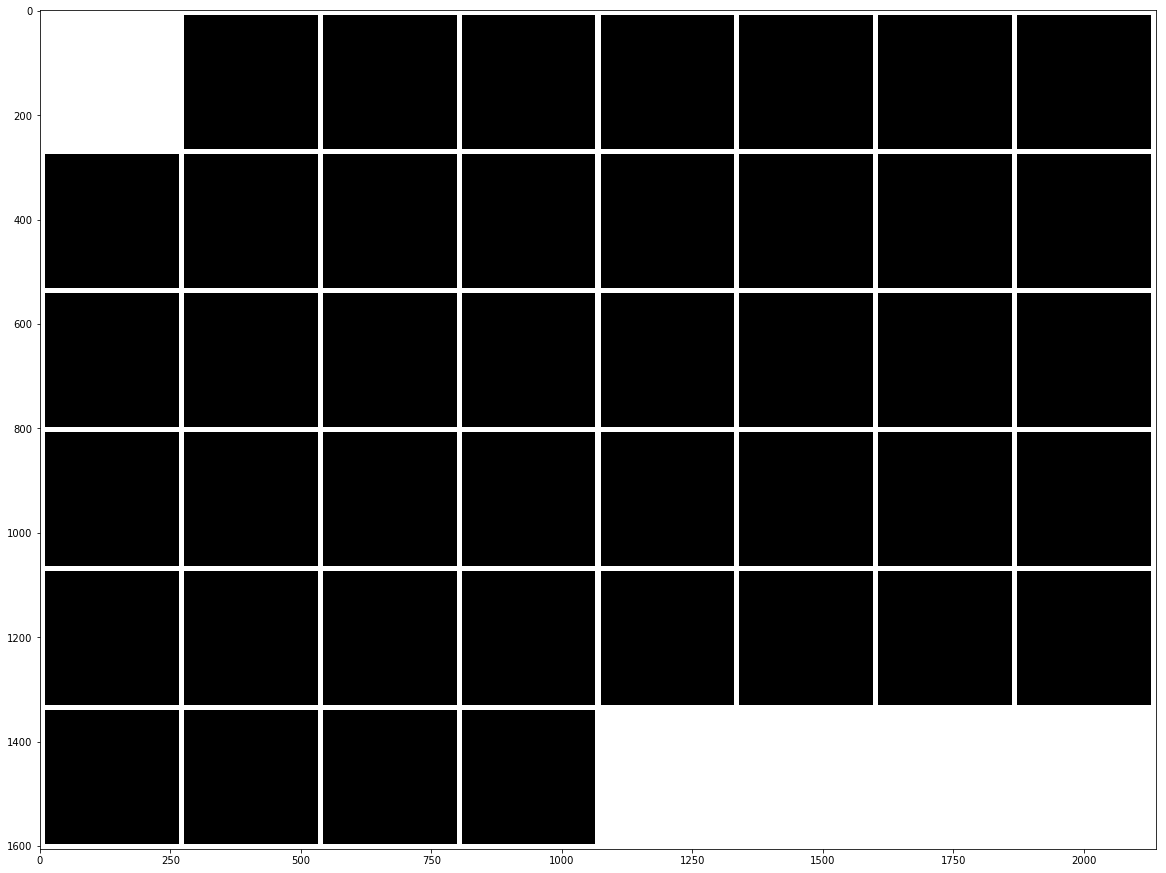

----------------------------------------------------------------------------------------------------
Prediction


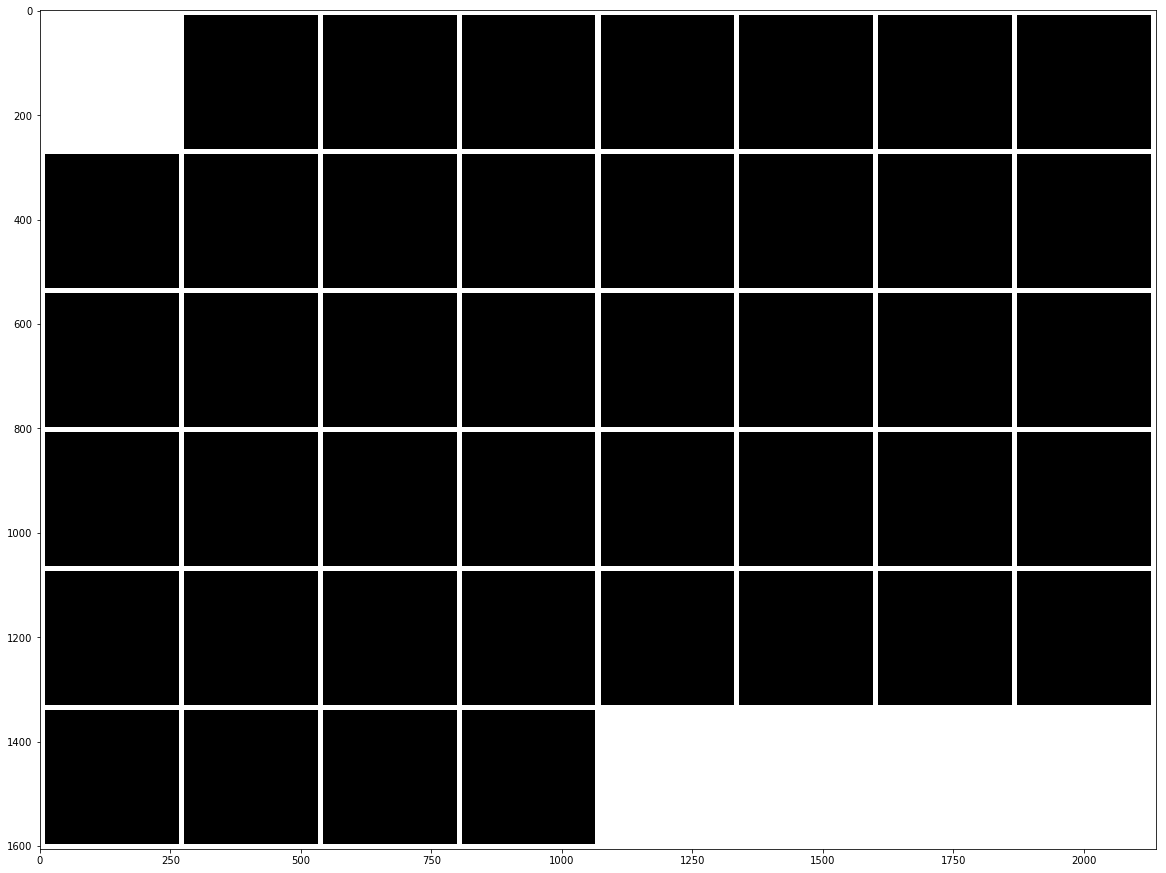

----------------------------------------------------------------------------------------------------
Ground Truth


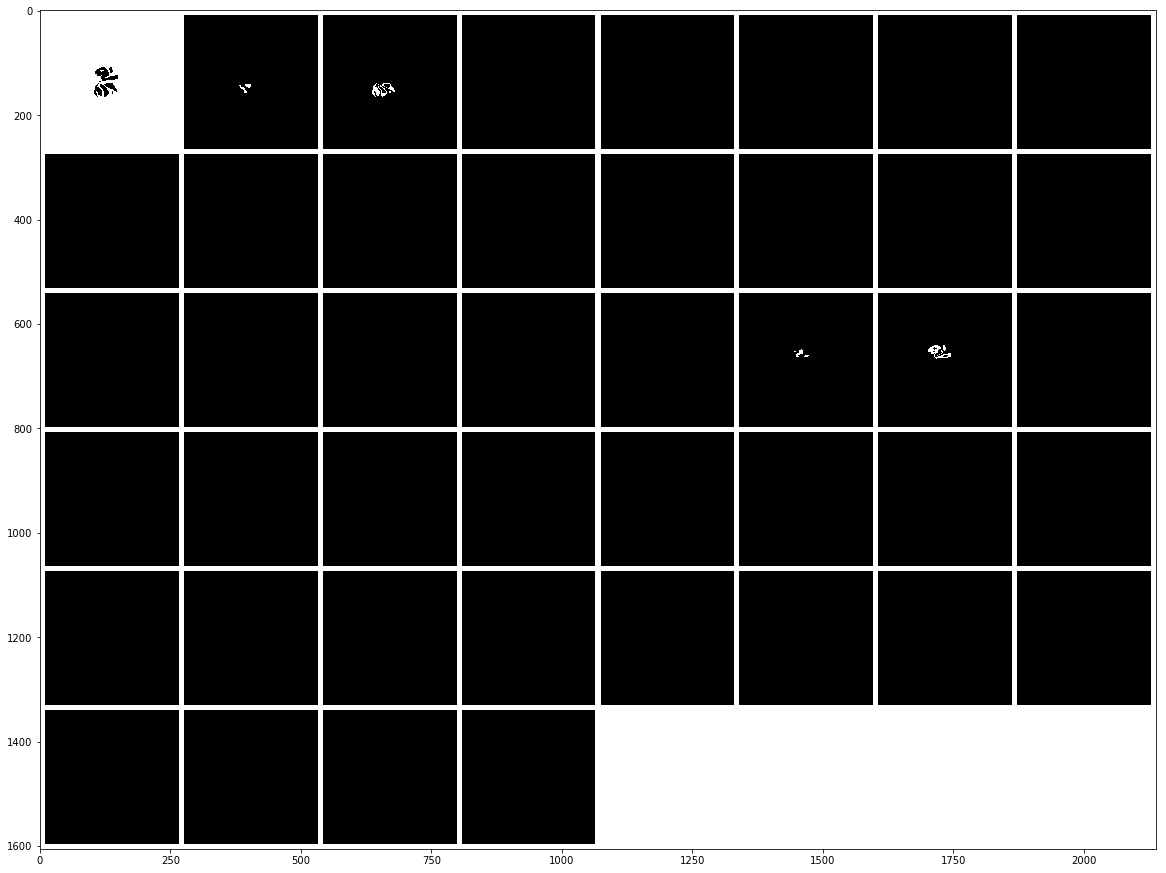

----------------------------------------------------------------------------------------------------
Prediction


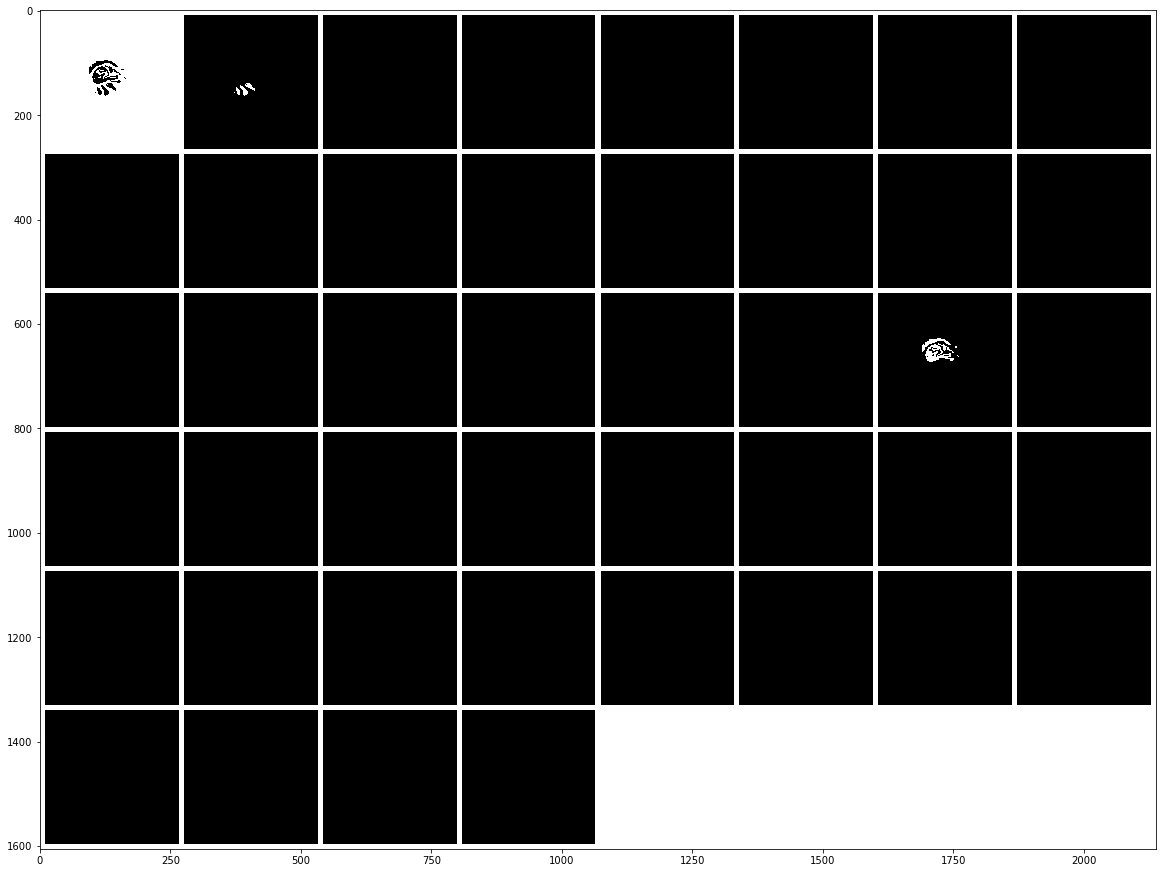

----------------------------------------------------------------------------------------------------
Ground Truth


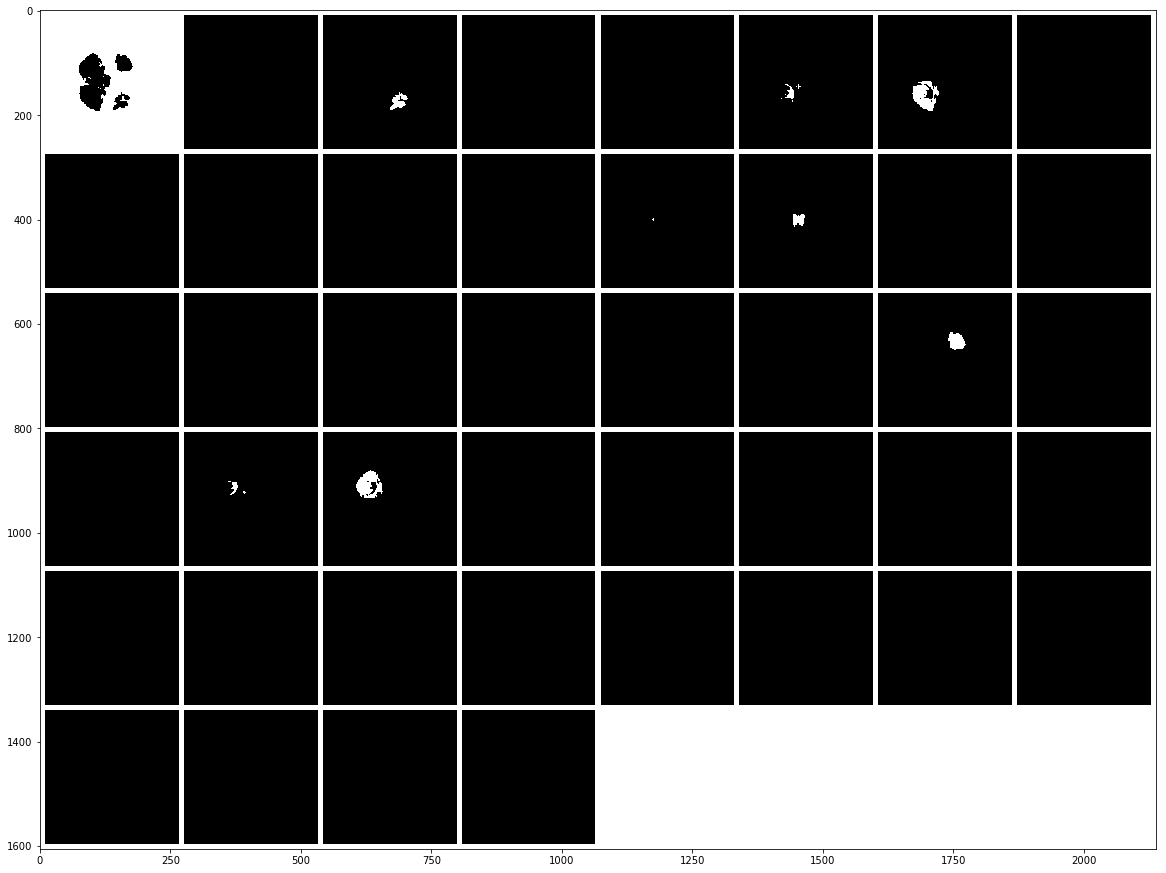

----------------------------------------------------------------------------------------------------
Prediction


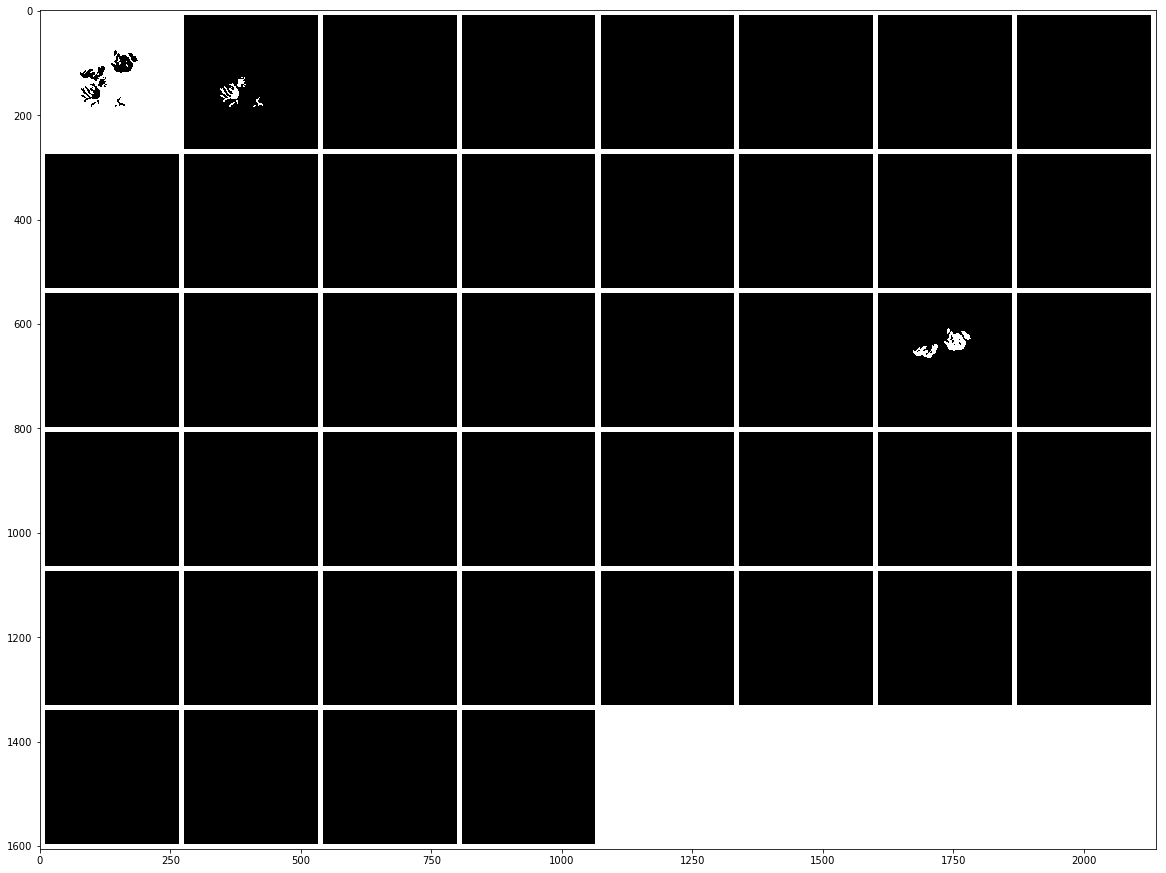

----------------------------------------------------------------------------------------------------
Ground Truth


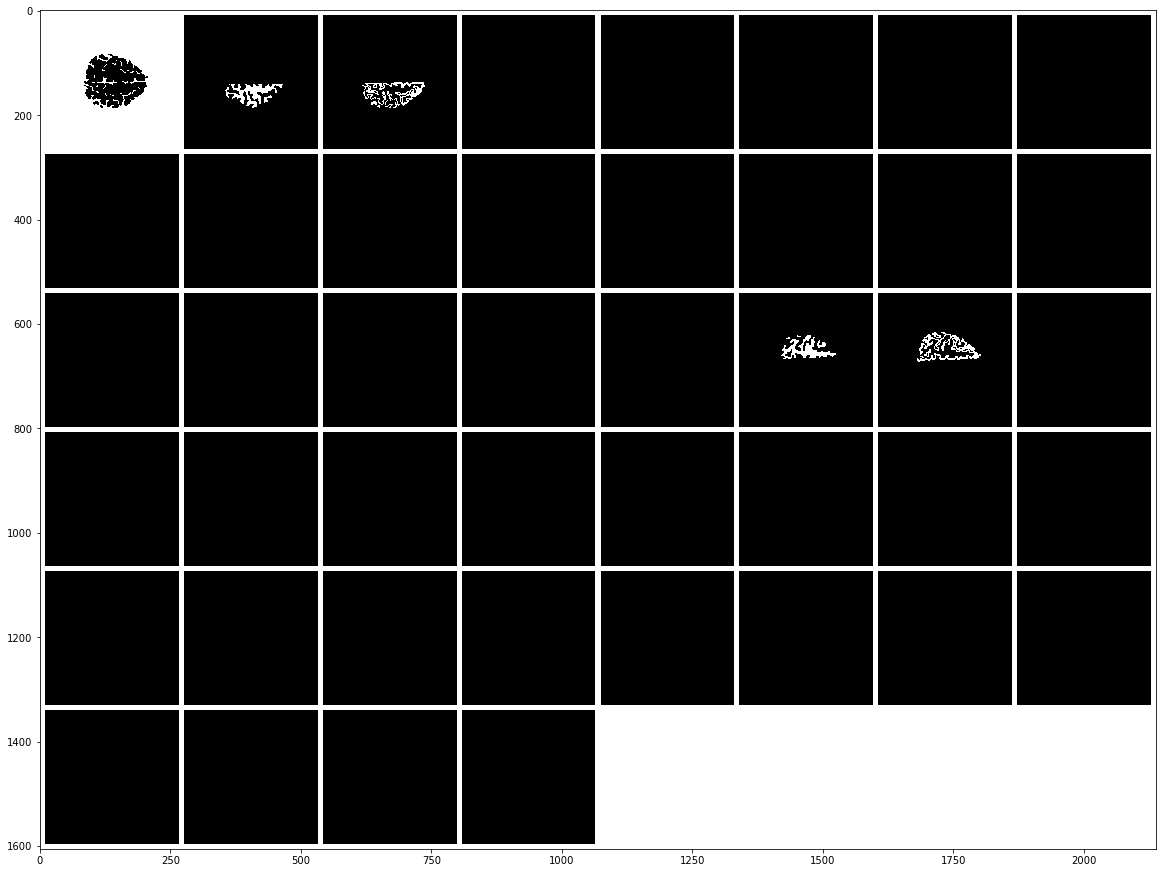

----------------------------------------------------------------------------------------------------
Prediction


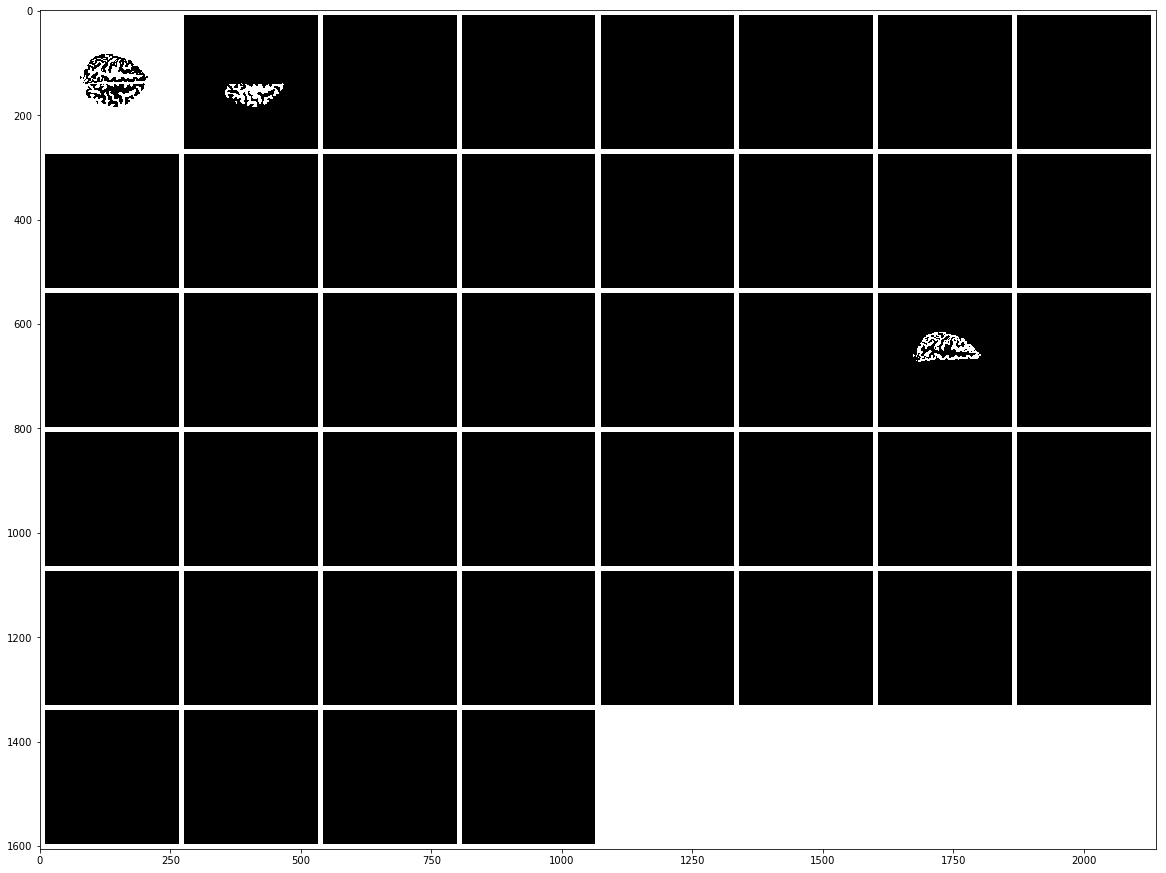

----------------------------------------------------------------------------------------------------
Ground Truth


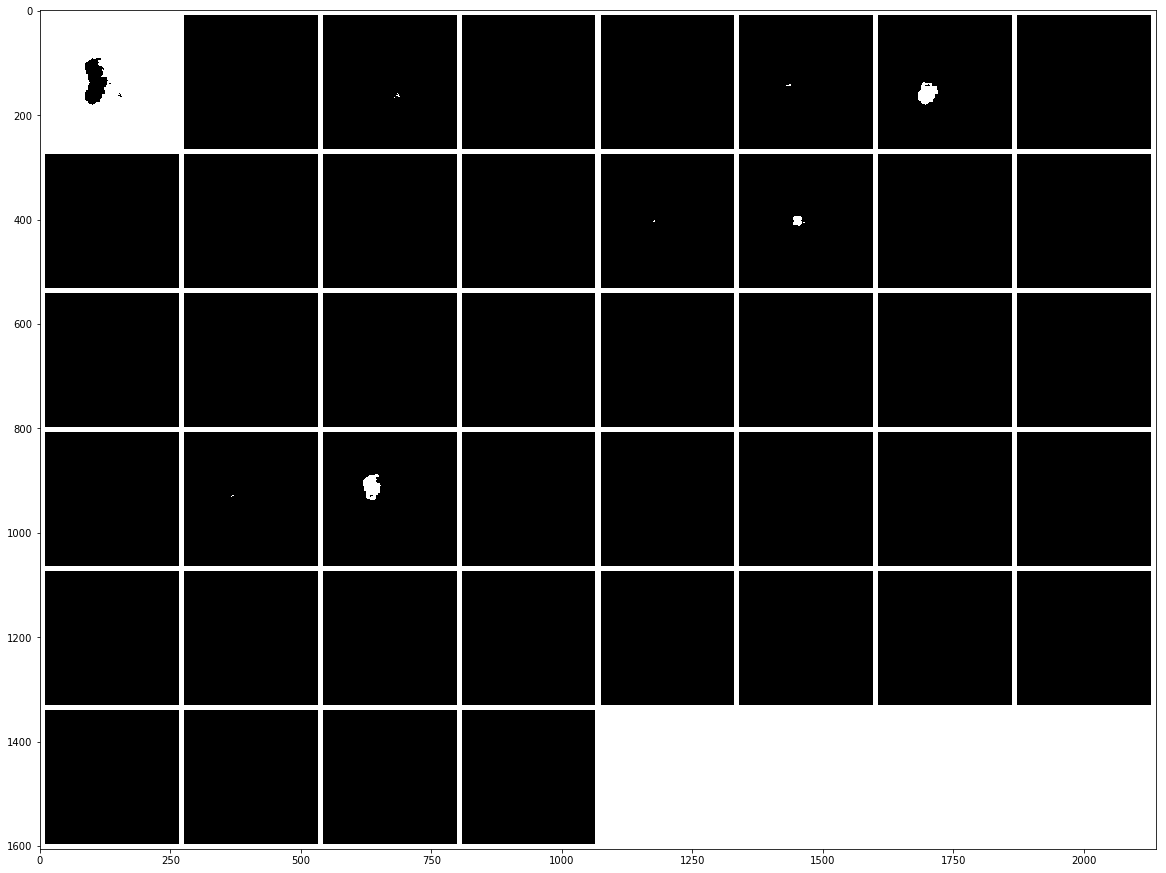

----------------------------------------------------------------------------------------------------
Prediction


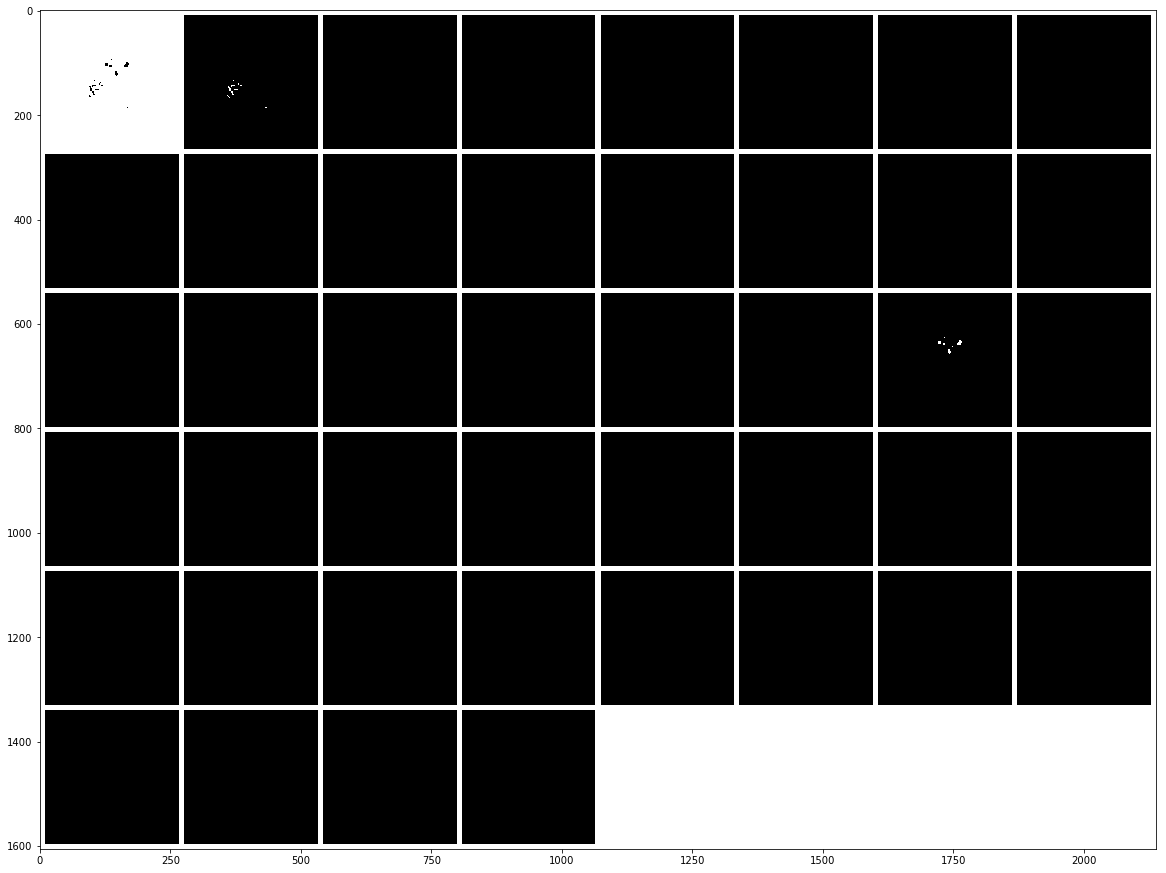

----------------------------------------------------------------------------------------------------
Ground Truth


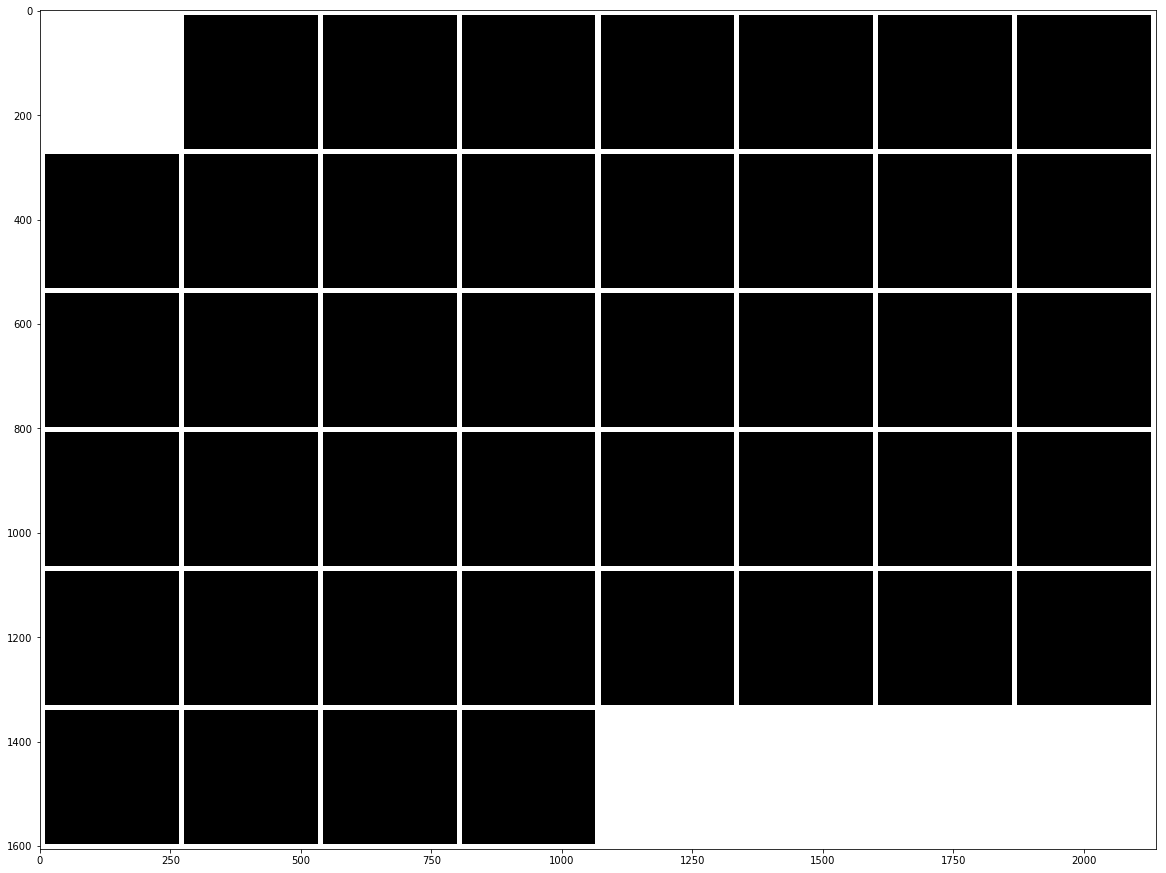

----------------------------------------------------------------------------------------------------
Prediction


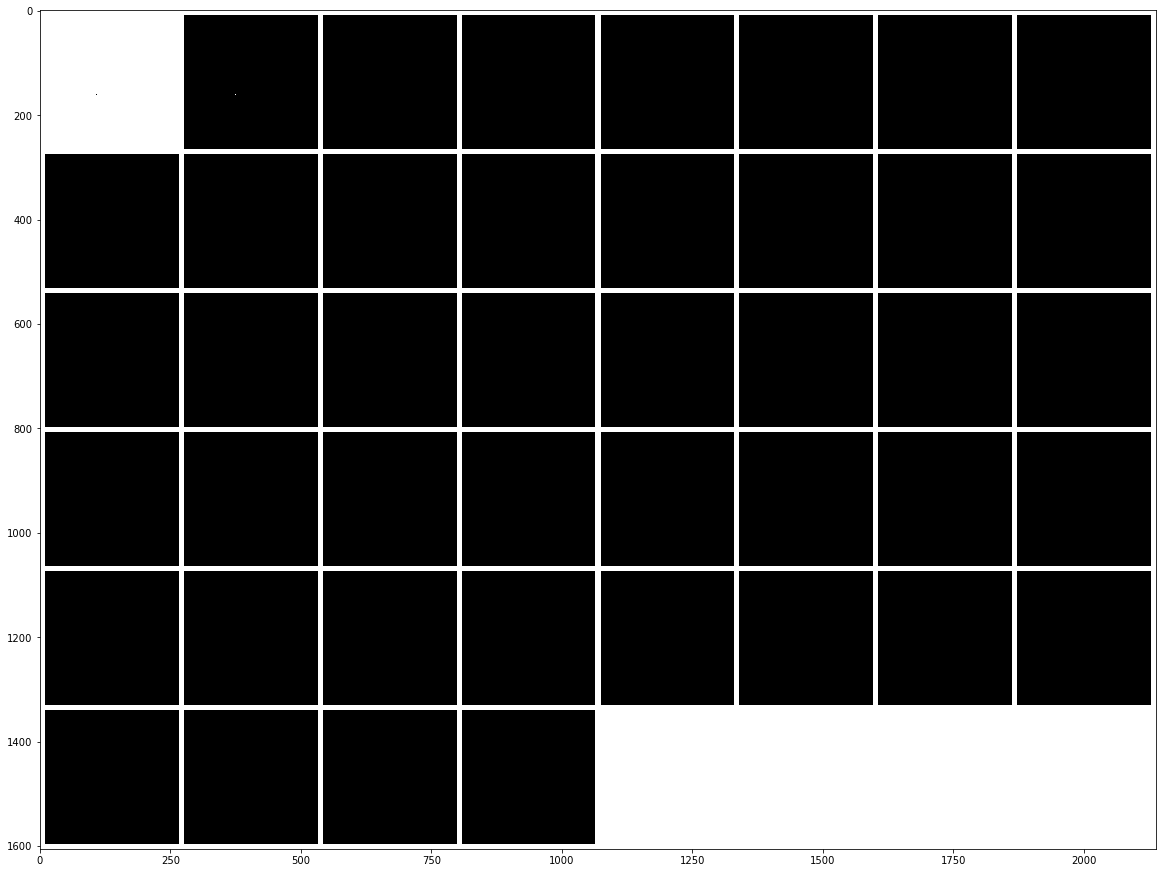

----------------------------------------------------------------------------------------------------
Ground Truth


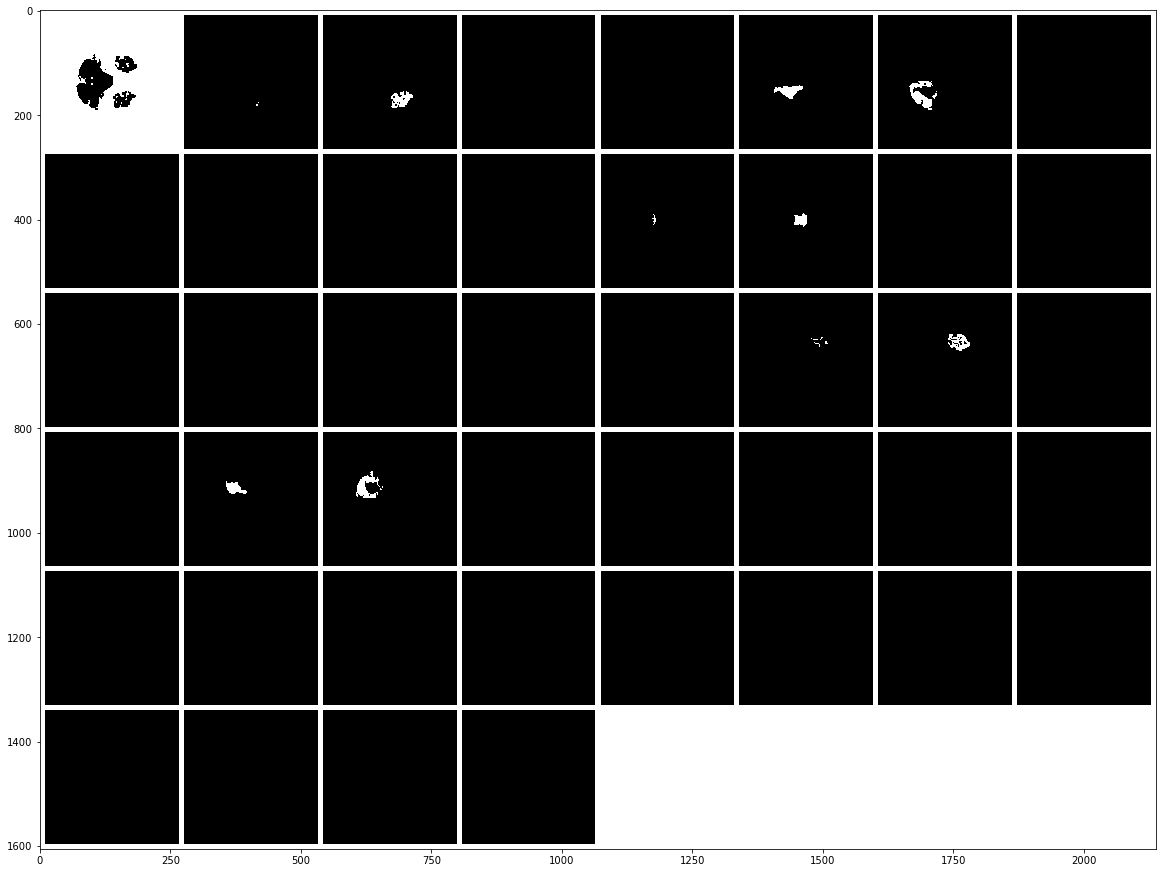

----------------------------------------------------------------------------------------------------
Prediction


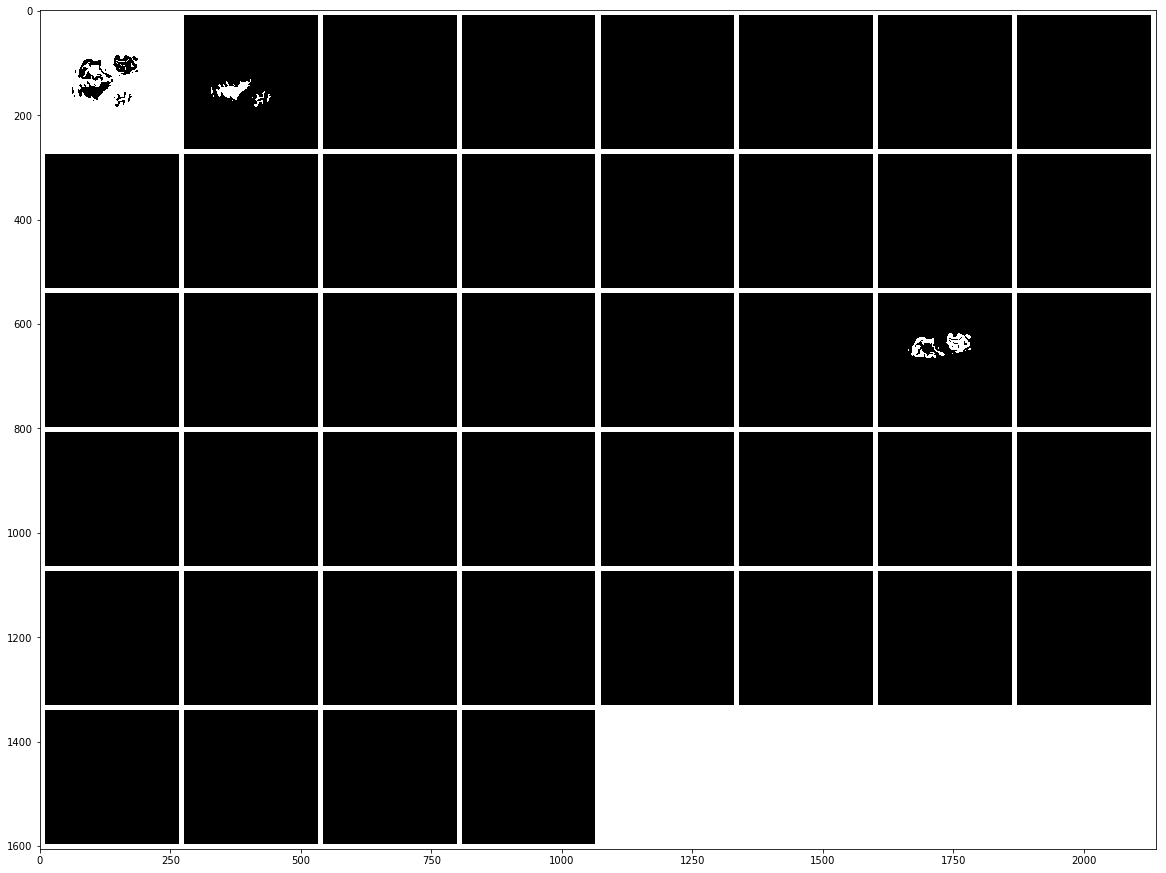

----------------------------------------------------------------------------------------------------
Ground Truth


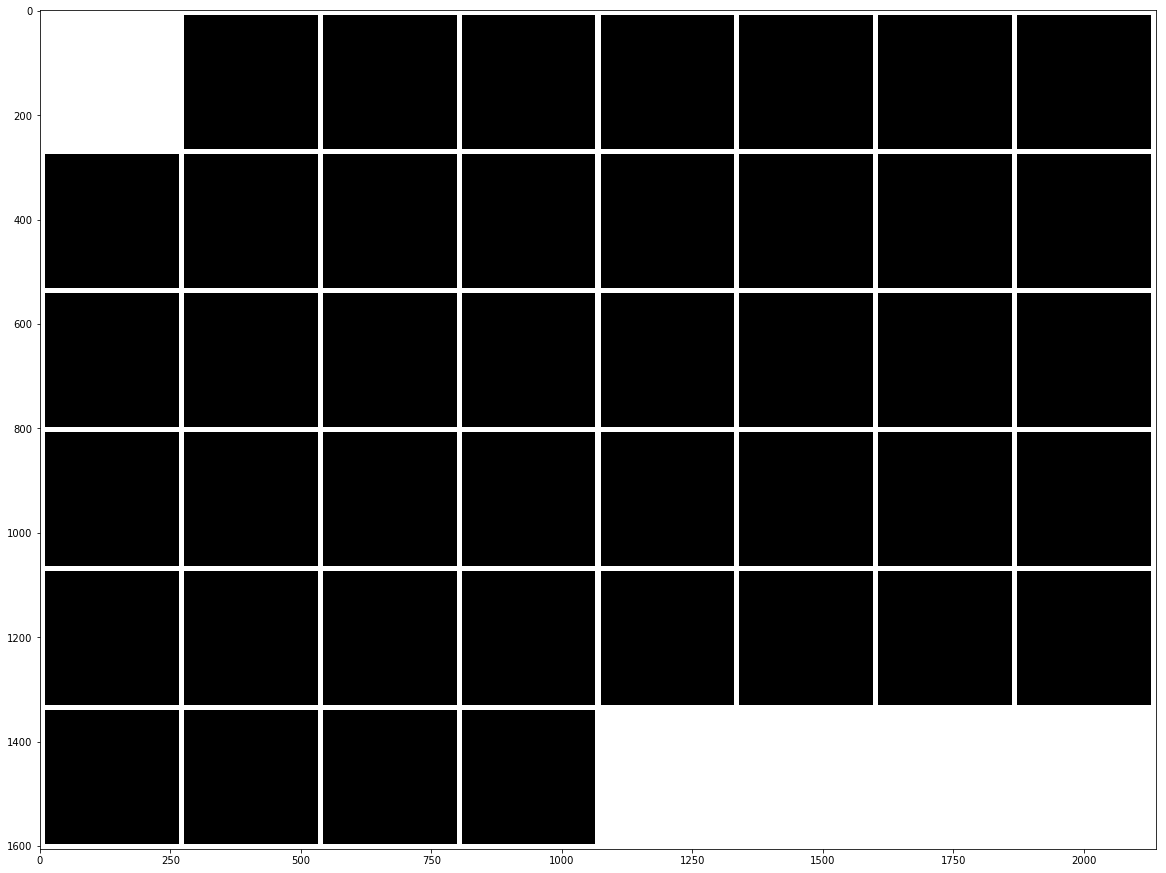

----------------------------------------------------------------------------------------------------
Prediction


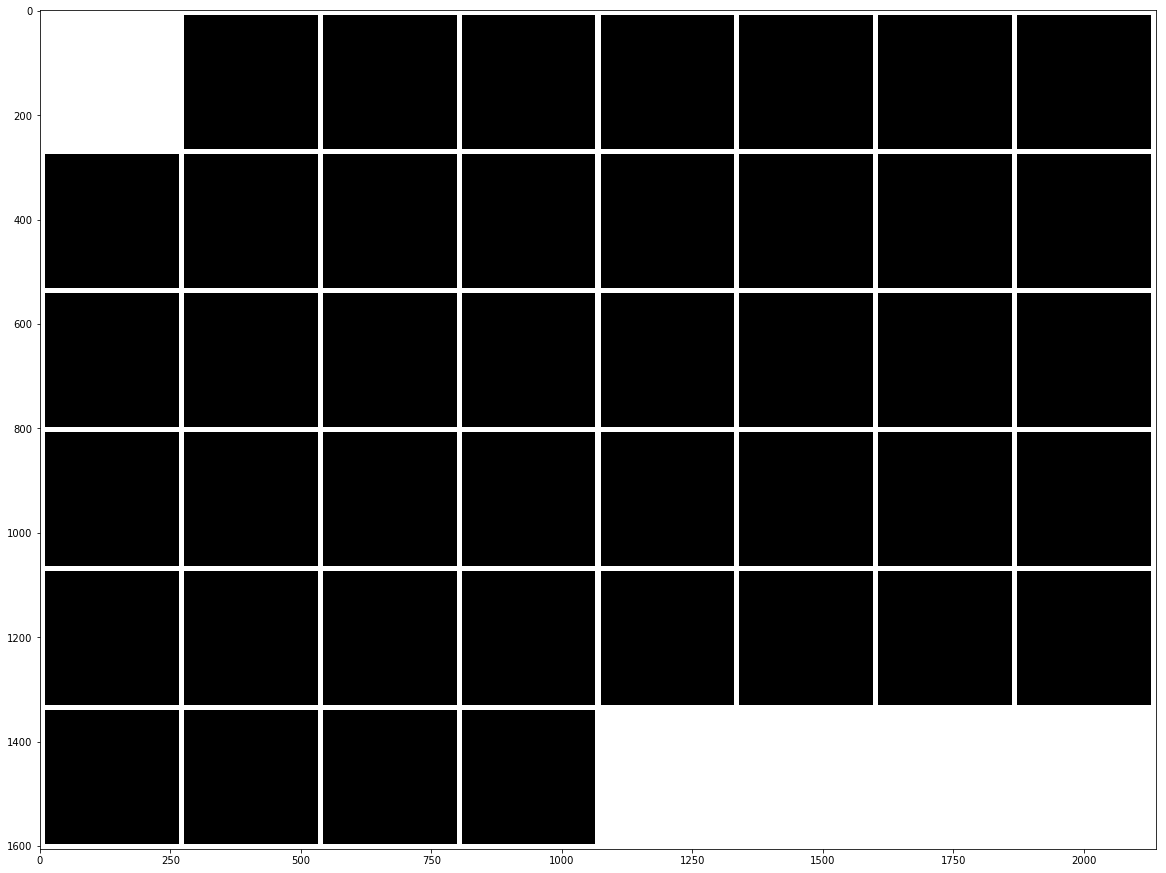

----------------------------------------------------------------------------------------------------
Ground Truth


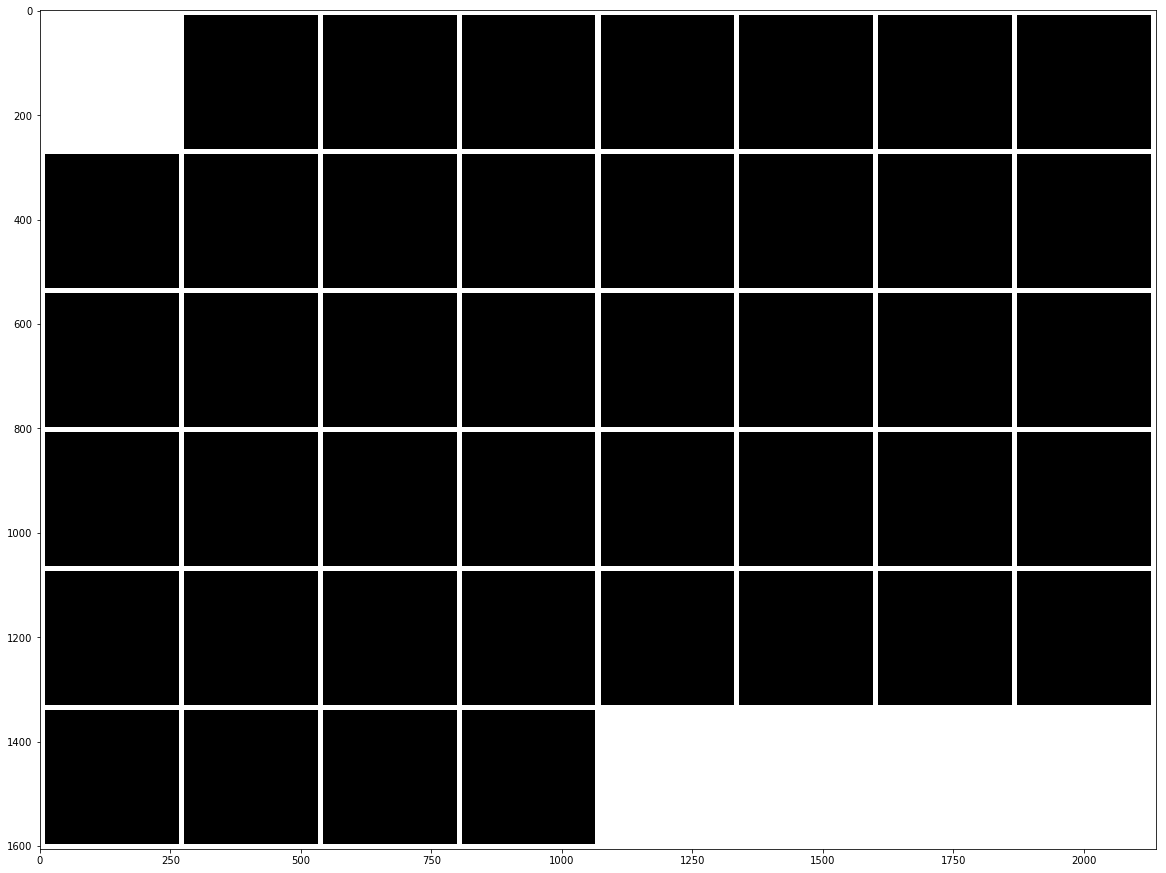

----------------------------------------------------------------------------------------------------
Prediction


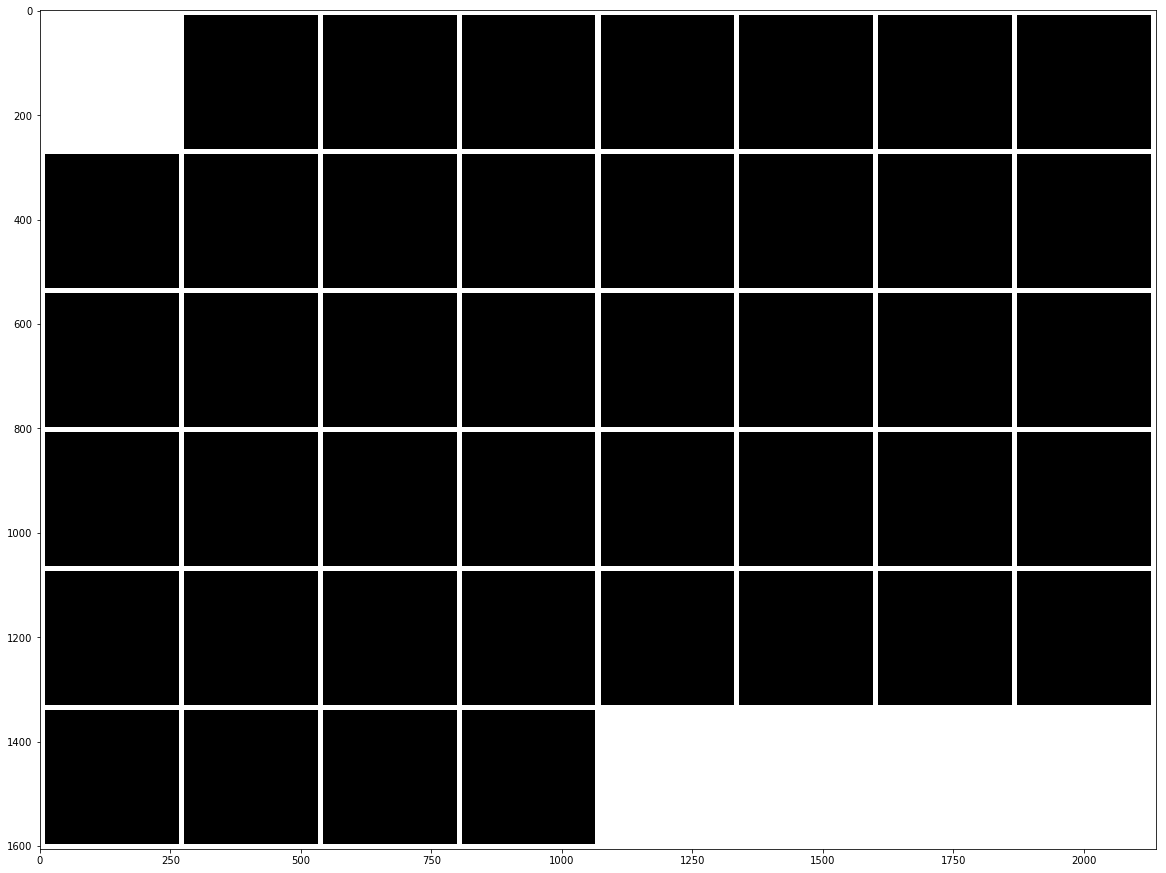

----------------------------------------------------------------------------------------------------
Ground Truth


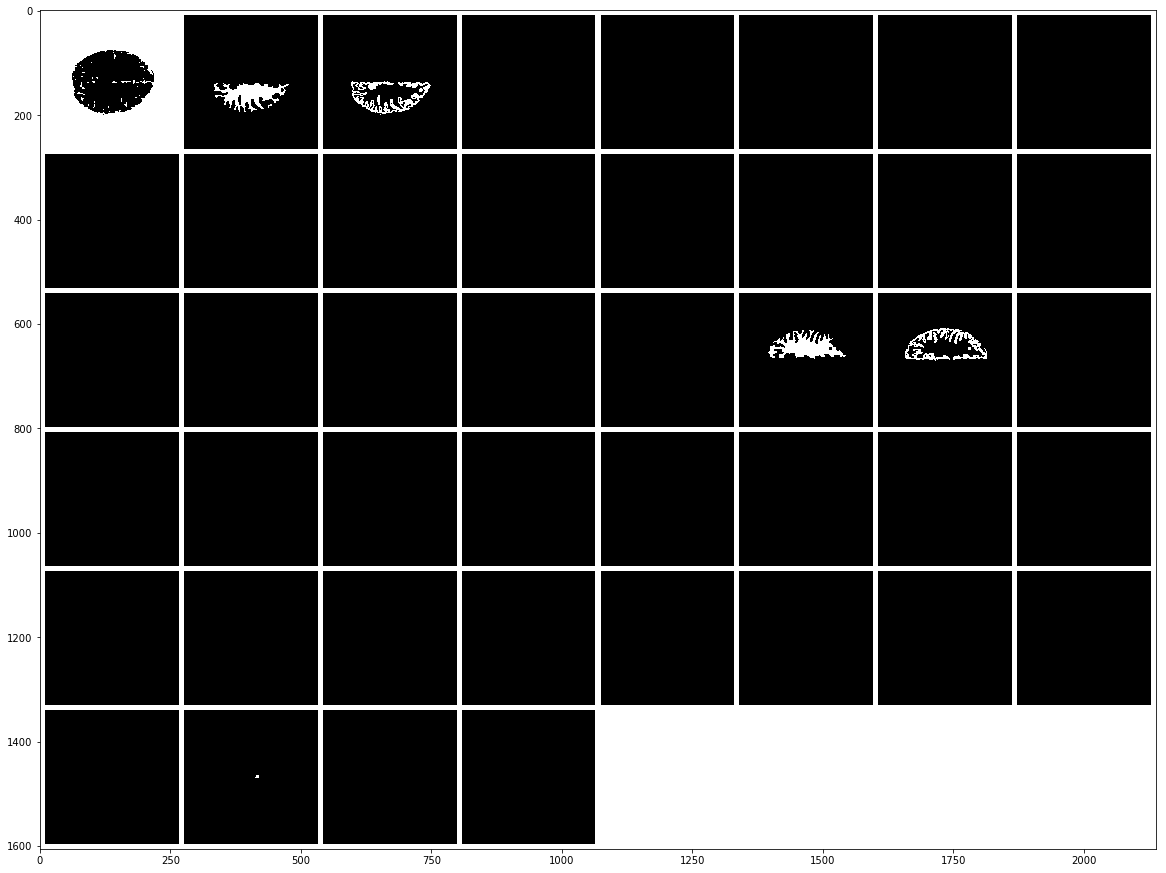

----------------------------------------------------------------------------------------------------
Prediction


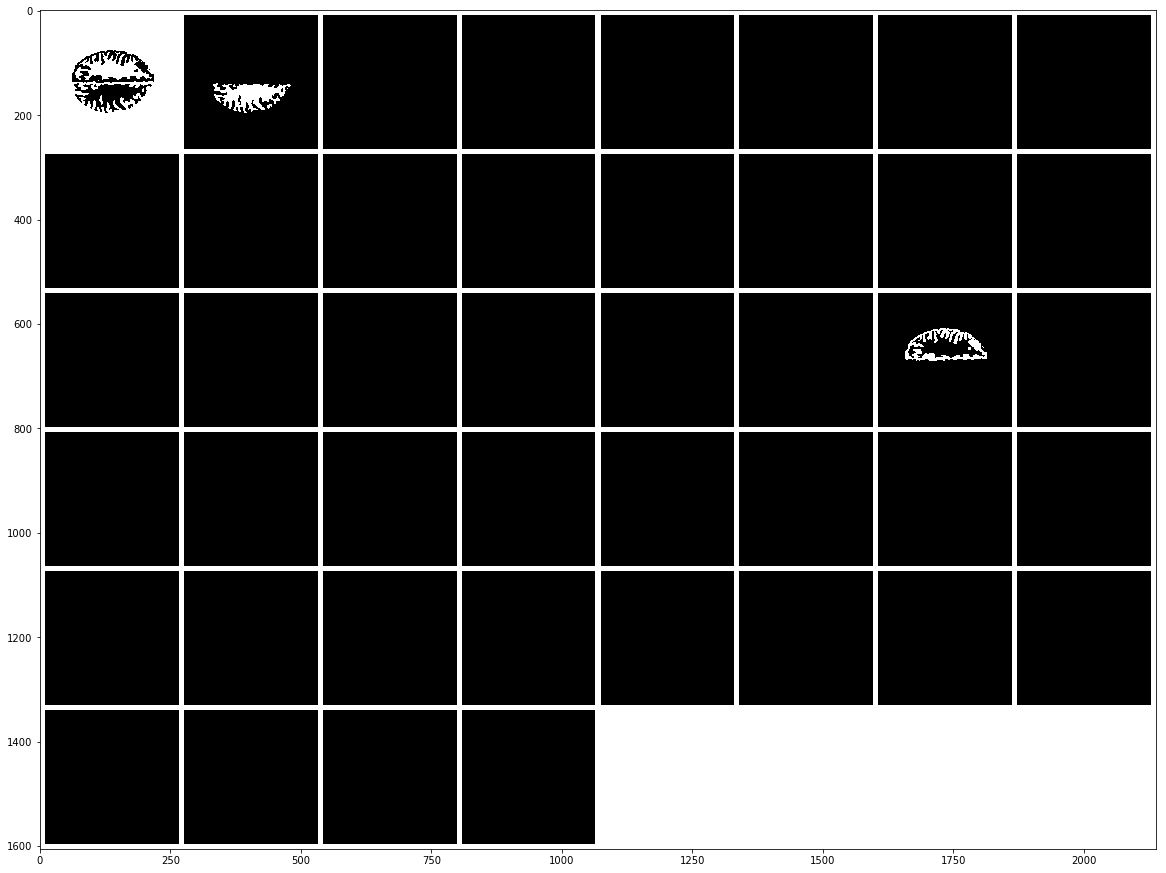

----------------------------------------------------------------------------------------------------
Ground Truth


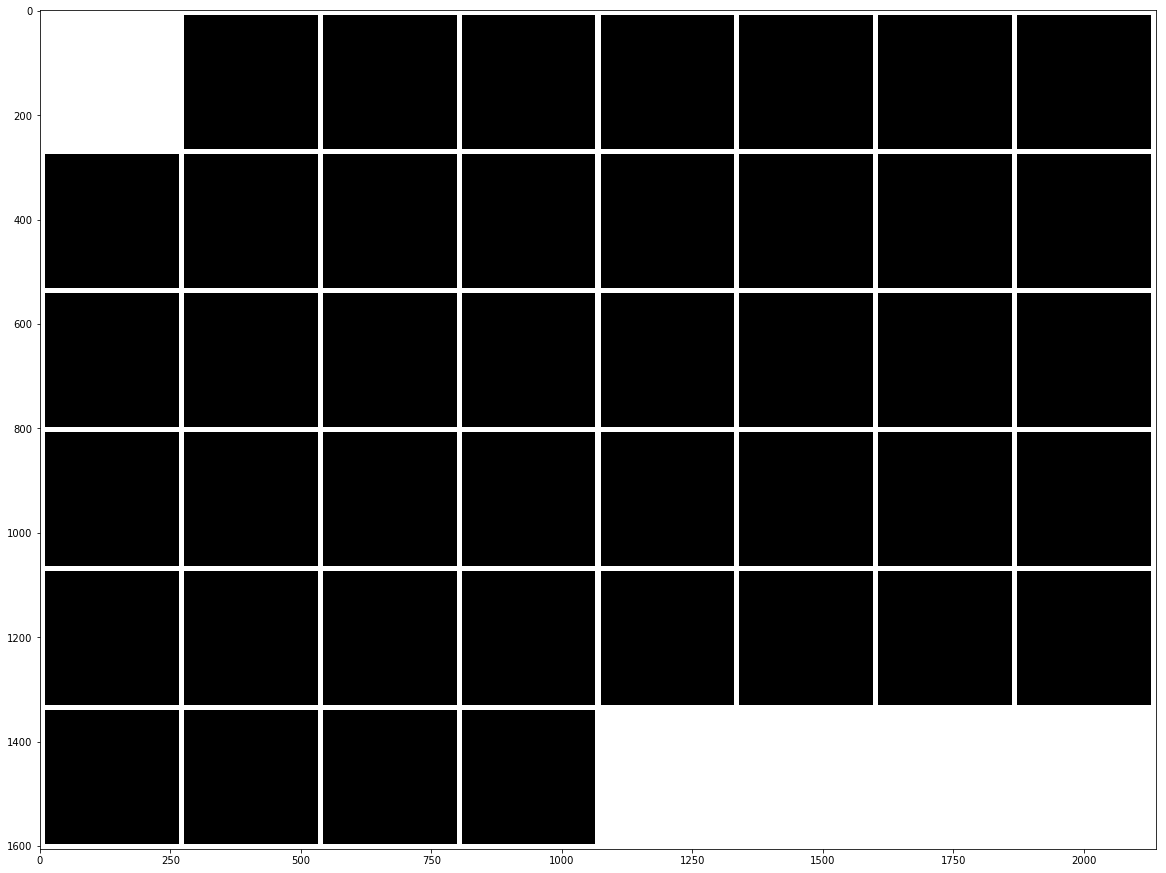

----------------------------------------------------------------------------------------------------
Prediction


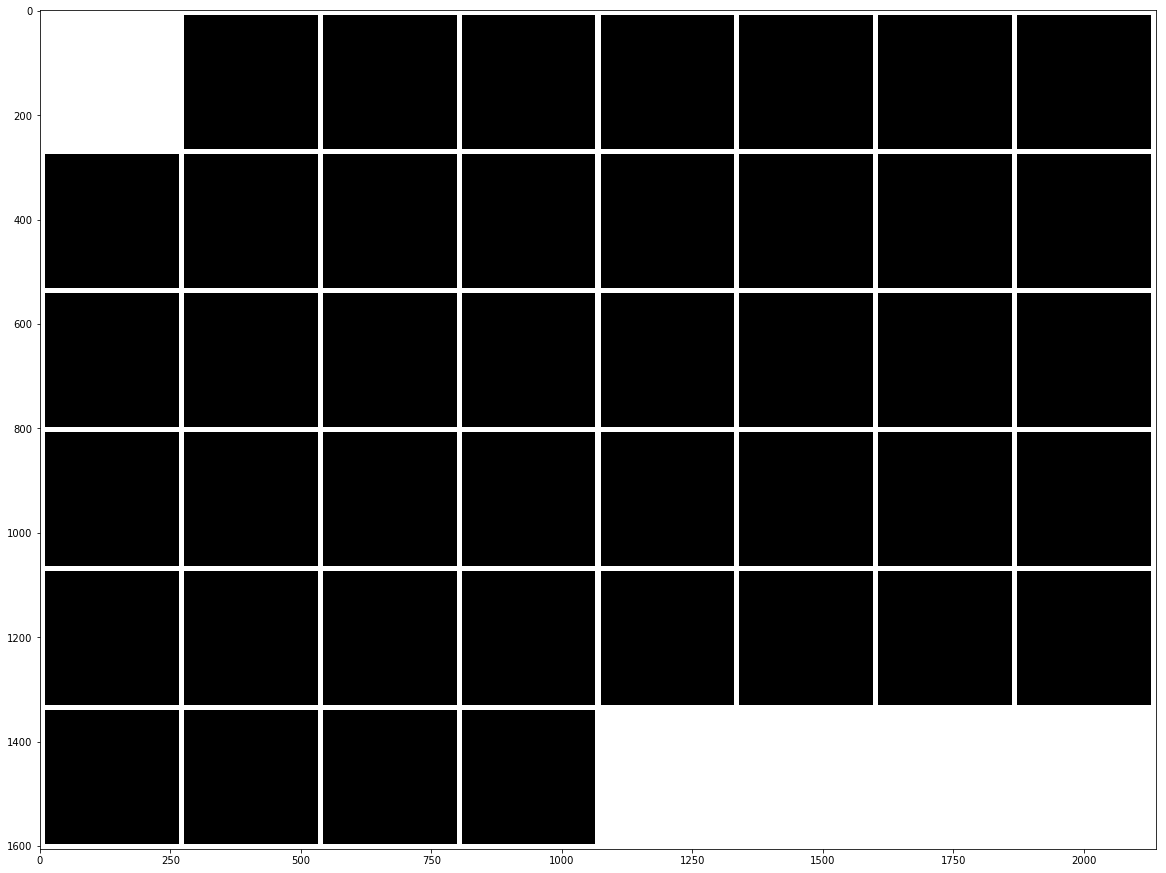

In [34]:
data = next(iter(dataloader["validate"]))
model.train(False)
x = data['x']
y = data['y']
x = Variable(x).type(torch.FloatTensor).cuda()
y = Variable(y).type(torch.FloatTensor).cuda()
                
output = model(x)
for i in range(11):
    print('-'*100)
    print('Ground Truth')
    abc = data['y'][i,:,:,:]
    bcd = abc.resize(44,1,256,256)
    show(make_grid(bcd,padding=10,pad_value=1)) 
    print('-'*100)
    print('Prediction')
    show(make_grid(visualize1(output[i,:,:,:]),padding=10,pad_value=1))
    
    